In [ ]:
!pip install koreanize-matplotlib

In [ ]:
df_all = pd.read_csv('/content/new_0418.csv')

In [ ]:
selected = pd.read_csv('/content/selected_features.csv')

In [ ]:
shap = ['PPI',
 '본원 통화(달러 발행량)',
 '수출물가지수(원화기준)',
 'NASDAQ',
 '미국PPI',
 'CPI',
 'KOSPI',
 '외환보유액(천달러)',
 '원유',
 '대외채무',
 '기준금리',
 '은',
 '수입물가지수(원화기준)',
 '장단기금리차',
 '뉴스심리지수',
 '금',
 'GDP_GROWTH(%)',
 '한국실업률',
 '위안화/달러']

In [ ]:
all.columns

Index(['DATE', 'GDP(십억원)', 'GNI(십억원)', 'GDP_GROWTH(%)', 'KOSPI', '국고채(3년)(%)',
       '국고채(10년)(%)', '뉴스심리지수', '경제심리지수', '수출금액지수', '수입금액지수', '수출물가지수(원화기준)',
       '수출물가지수(계약통화기준)', '수출물가지수(달러기준)', '수입물가지수(원화기준)', '수입물가지수(계약통화기준)',
       '수입물가지수(달러기준)', '대외채권', '대외채무', '순대외채권', '외환보유액(천달러)', '기준금리',
       'CD(91일)', '무담보콜금리(1일, 전체거래)', '경상수지(계절조정)', 'CPI', 'PPI',
       '원/미국달러(매매기준율)', '일본엔/달러', '달러/유로', '미국기준금리', 'NASDAQ', '위안화/달러',
       '미국CPI', '미국PPI', '본원 통화(달러 발행량)', '미국 소비자심리지수', '금', '은', '원유',
       '한국실업률', '미국실업률'],
      dtype='object')

In [ ]:
selected.columns

Index(['DATE', 'KOSPI', '기준금리', '수출물가지수(원화기준)', '수입물가지수(원화기준)', 'PPI', '한국실업률',
       '금', '은', '원유', '중국위안/달러', 'NASDAQ', '외환보유액(천달러)', '미국PPI', '뉴스심리지수',
       '대외채무', '본원 통화(달러 발행량)', 'CPI', '장단기금리차', 'GDP_GROWTH(%)',
       '원/미국달러(매매기준율)'],
      dtype='object')

In [ ]:
shap

['PPI',
 '본원 통화(달러 발행량)',
 '수출물가지수(원화기준)',
 'NASDAQ',
 '미국PPI',
 'CPI',
 'KOSPI',
 '외환보유액(천달러)',
 '원유',
 '대외채무',
 '기준금리',
 '은',
 '수입물가지수(원화기준)',
 '장단기금리차',
 '뉴스심리지수',
 '금',
 'GDP_GROWTH(%)',
 '한국실업률',
 '위안화/달러']

In [ ]:
# ✅ 필요 패키지
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import koreanize_matplotlib

# ✅ 설정
LOOKBACK = 30
TARGET = "원/미국달러(매매기준율)"

# ✅ 데이터 준비 (정규화 포함)
df = df_all.dropna().copy()
df = df.sort_values("DATE").reset_index(drop=True)
df["Target"] = np.log1p(df[TARGET])

# ✅ 쉼표 제거 및 수치형 변환 (DATE 제외)
for col in df.columns:
    if col == "DATE":
        continue
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

features_all = df.columns.drop(["DATE", "Target"])
scaler_all = MinMaxScaler()
scaled_all = scaler_all.fit_transform(df[features_all])

# ✅ 시퀀스 생성 함수
def create_sequences(data, target, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(scaled_all, df["Target"].values, LOOKBACK)

# ✅ 학습/테스트 분리
dates_all = df["DATE"][LOOKBACK:].reset_index(drop=True)
train_idx_all = dates_all <= "2021-12-31"
X_train_all, X_test_all = X_all[train_idx_all], X_all[~train_idx_all]
y_train_all, y_test_all = y_all[train_idx_all], y_all[~train_idx_all]

# ✅ LSTM 모델 구성 및 학습
model_all = Sequential([
    LSTM(64, input_shape=(LOOKBACK, X_all.shape[2])),
    Dense(1)
])
model_all.compile(optimizer='adam', loss='mse')
model_all.fit(X_train_all, y_train_all, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

# ✅ Rolling 예측 함수
def forecast_lstm_rolling(model, last_sequence_raw, scaler, target_index, n_days=30):
    forecast = []
    current_seq = last_sequence_raw.copy()

    for _ in range(n_days):
        scaled_seq = scaler.transform(current_seq)
        pred_log = model.predict(scaled_seq[np.newaxis, :, :])[0, 0]
        pred_val = np.expm1(pred_log)
        forecast.append(pred_val)

        # 새로운 row 갱신 (예측값으로 환율 값만 업데이트)
        next_row = current_seq[-1].copy()
        next_row[target_index] = pred_val
        current_seq = np.vstack([current_seq[1:], next_row])

    return forecast

# ✅ 예측 실행
last_sequence_raw = df[features_all].iloc[-LOOKBACK:].values
target_index_all = list(features_all).index(TARGET)
future_preds_all = forecast_lstm_rolling(model_all, last_sequence_raw, scaler_all, target_index_all, n_days=30)

# ✅ 시각화용 날짜
future_dates = pd.date_range(start=df["DATE"].max() + pd.Timedelta(days=1), periods=30)

# ✅ Prophet 스타일 시각화
plt.figure(figsize=(14, 6))
plt.plot(future_dates, future_preds_all, '--o', label="LSTM 예측 (전체 피처)", color='orange')
plt.axvline(x=df["DATE"].max(), linestyle=':', color='gray', label='기준일')
plt.title("📈 LSTM 환율 30일 예측 (전체피처 기반, Prophet 스타일)")
plt.xlabel("날짜")
plt.ylabel("예측 환율 (원/달러)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
def forecast_lstm_rolling_realistic(model, last_sequence, scaler, target_index, feature_names, n_days=30):
    forecast = []
    current_seq = last_sequence.copy()  # shape: (30, num_features)

    # 변화가 자연스러운 feature 인덱스 (예시: KOSPI, 금, 유가 등)
    dynamic_features = ['KOSPI', '금', '원유']
    dynamic_indices = [feature_names.index(feat) for feat in dynamic_features if feat in feature_names]

    for _ in range(n_days):
        # 1. 예측 (log scale → 원단위)
        pred_log = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        pred_val = np.expm1(pred_log)
        forecast.append(pred_val)

        # 2. 다음 시퀀스를 위한 새 row 생성
        next_row = current_seq[-1].copy()
        next_row[target_index] = scaler.data_max_[target_index]  # 역정규화 대응

        # 변화가 클 수 있는 피처를 약간씩 변동 (노이즈 추가)
        for idx in dynamic_indices:
            noise = np.random.normal(0, 0.01)  # 1% 수준 노이즈
            next_row[idx] = next_row[idx] * (1 + noise)
            # 클리핑 (0~1 범위 유지)
            next_row[idx] = np.clip(next_row[idx], 0, 1)

        # 예측된 환율 값 반영 (정규화된 값으로)
        pred_scaled = (pred_val - scaler.data_min_[target_index]) / (scaler.data_max_[target_index] - scaler.data_min_[target_index])
        next_row[target_index] = np.clip(pred_scaled, 0, 1)

        # 3. 시퀀스 업데이트
        current_seq = np.vstack([current_seq[1:], next_row])

    return forecast

In [ ]:
last_sequence_raw = df_all.dropna().sort_values("DATE").drop(columns=["DATE", "Target"]).iloc[-LOOKBACK:].values
target_index = list(features_all).index("원/미국달러(매매기준율)")

future_preds_real = forecast_lstm_rolling_realistic(
    model_all,
    last_sequence=scaled_all[-LOOKBACK:],  # 정규화된 시퀀스
    scaler=scaler_all,
    target_index=target_index,
    feature_names=list(features_all),
    n_days=30
)

KeyError: "['Target'] not found in axis"

In [ ]:
import koreanize_matplotlib

future_dates = pd.date_range(start=df_all["DATE"].max() + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14, 6))
plt.plot(future_dates, future_preds_real, marker='o', linestyle='-', label="LSTM 예측 (현실적)")
plt.axvline(df_all["DATE"].max(), color='gray', linestyle=':', label="기준일")
plt.title("LSTM 기반 30일 환율 예측")
plt.xlabel("날짜")
plt.ylabel("예측 환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: can only concatenate str (not "Timedelta") to str

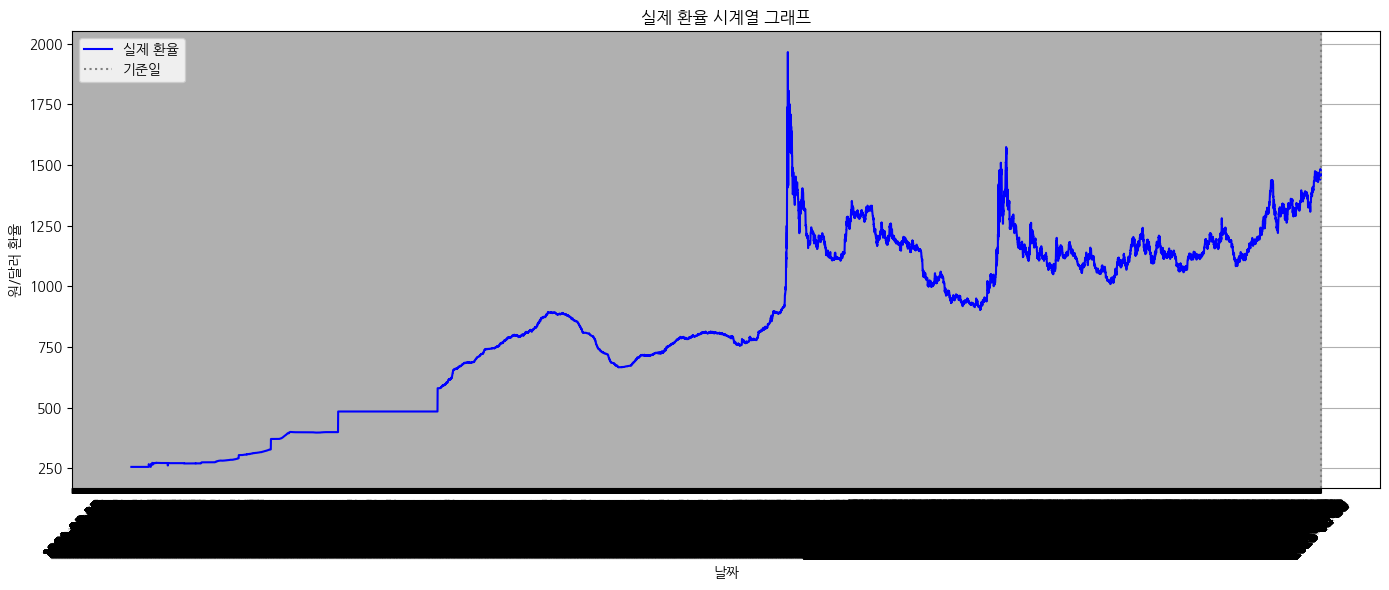

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 날짜, 환율 데이터 준비
dates = df_all["DATE"]
exchange_rates = df_all["원/미국달러(매매기준율)"]

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(dates, exchange_rates, color='blue', label='실제 환율')
plt.axvline(dates.max(), color='gray', linestyle=':', label='기준일')
plt.title("실제 환율 시계열 그래프")
plt.xlabel("날짜")
plt.ylabel("원/달러 환율")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ✅ 기준일 및 구간 설정
cutoff_date = df_all["DATE"].max()
start_date = pd.to_datetime("2025-01-01")
future_dates = pd.date_range(start=cutoff_date + pd.Timedelta(days=1), periods=30)

# ✅ 실제 환율 데이터 (2024년 1월부터)
mask = df_all["DATE"] >= start_date
dates_actual = df_all.loc[mask, "DATE"]
rates_actual = df_all.loc[mask, "원/미국달러(매매기준율)"]

# ✅ 시각화
plt.figure(figsize=(15, 6))

# 1. 실제 환율
plt.plot(dates_actual, rates_actual, label="실제 환율", color='blue', linewidth=2)

# 2. 예측 환율
plt.plot(future_dates, future_preds_real, label="LSTM 예측 환율", color='orange', linestyle='--', linewidth=2, marker='o', markersize=6)

# 3. 예측 기간 강조 (음영)
plt.axvspan(future_dates[0], future_dates[-1], color='orange', alpha=0.08, label='예측 구간')

# 4. 기준일 표시
plt.axvline(cutoff_date, color='gray', linestyle='--', label='기준일')

# ✅ 스타일 설정
plt.title("📈 2024년 1월부터 실제 환율 vs LSTM 30일 예측", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: can only concatenate str (not "Timedelta") to str

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_lstm_rolling(model, df, scaler, features, target_col, lookback=30, days=10):
    """
    ✅ LSTM으로 1일 후, 2일 후 ... N일 후 환율 예측 및 정확도 계산 (Rolling 방식)
    """
    df_sorted = df.sort_values("DATE").reset_index(drop=True)
    df_sorted["Target"] = np.log1p(df_sorted[target_col])
    df_filtered = df_sorted.dropna().reset_index(drop=True)

    # 마지막 시퀀스 (raw + scaling)
    last_seq_raw = df_filtered[features].iloc[-lookback:].values
    last_seq_scaled = scaler.transform(last_seq_raw)
    target_idx = list(features).index(target_col)

    # 실제 환율 데이터 준비
    true_target = df_filtered[target_col].iloc[-days:].values[::-1]  # 최신부터 최근 10일

    preds, maes, rmses = [], [], []
    current_seq = last_seq_scaled.copy()

    for i in range(days):
        # ✅ 예측 (log scale → 원화)
        pred_log = model.predict(current_seq[np.newaxis, :, :], verbose=0)[0, 0]
        pred_val = np.expm1(pred_log)
        preds.append(pred_val)

        # 실제값
        true_val = true_target[i]
        mae = np.abs(pred_val - true_val)
        rmse = np.sqrt((pred_val - true_val) ** 2)

        maes.append(mae)
        rmses.append(rmse)

        # 새 row 생성
        last_row_raw = df_filtered[features].iloc[-1].copy().values
        last_row_raw[target_idx] = pred_val
        new_row_scaled = scaler.transform([last_row_raw])[0]

        current_seq = np.vstack([current_seq[1:], new_row_scaled])

    # 결과 정리
    result_df = pd.DataFrame({
        "Day": [f"{i+1}일후" for i in range(days)],
        "예측환율": preds,
        "실제환율": true_target,
        "MAE": maes,
        "RMSE": rmses
    })

    return result_df

In [ ]:
result_df = evaluate_lstm_rolling(
    model=model_all,               # 학습된 LSTM 모델
    df=df_all,                     # 전체 DataFrame (DATE, 피처 포함)
    scaler=scaler_all,            # 학습에 사용된 MinMaxScaler
    features=features_all,        # 스케일링에 사용한 피처 리스트
    target_col="원/미국달러(매매기준율)",  # 예측 대상 컬럼
    lookback=30,
    days=10
)

print(result_df)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: '17,754.09'

In [ ]:
print("데이터셋의 최대 날짜:", df_all["DATE"].max())
print("2025-04-01 이후 데이터 존재 여부:")
print(df_all[df_all["DATE"] > pd.to_datetime("2025-04-01")][["DATE", "원/미국달러(매매기준율)"]])

데이터셋의 최대 날짜: 2025-04-13
2025-04-01 이후 데이터 존재 여부:


TypeError: '>' not supported between instances of 'str' and 'Timestamp'

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 7.8670 - val_loss: 0.0037
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0053 - val_loss: 0.0131
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029 - val_loss: 0.0104
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.7797e-04 - val_loss: 0.0056
Epoch 7/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.6626e-04 - val_loss: 0.0038
Epoch 8/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.1683e-04 - val_loss: 0.0022
Epoch 9/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.2607e-04 - val_loss: 0.0022
Epoch 10/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.7615e-04 - val_loss: 0.0017
Epoch 11/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.4164e-04 - val_loss: 0.0020
Epoch 12/30
208/208 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,날짜,예측환율,실제환율,MAE,RMSE
0,2025-04-02,1403.133545,1471.7,68.566455,68.566455
1,2025-04-03,1403.627075,1467.8,64.172925,64.172925
2,2025-04-04,1403.959351,1467.0,63.040649,63.040649
3,2025-04-05,1404.168335,1467.0,62.831665,62.831665
4,2025-04-06,1404.301758,1467.0,62.698242,62.698242
5,2025-04-07,1404.387451,1439.3,34.912549,34.912549
6,2025-04-08,1404.443115,1465.9,61.456885,61.456885
7,2025-04-09,1404.476562,1470.2,65.723438,65.723438
8,2025-04-10,1404.500732,1482.9,78.399268,78.399268
9,2025-04-11,1404.515503,1458.5,53.984497,53.984497


<ipython-input-53-8558ea438063>:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


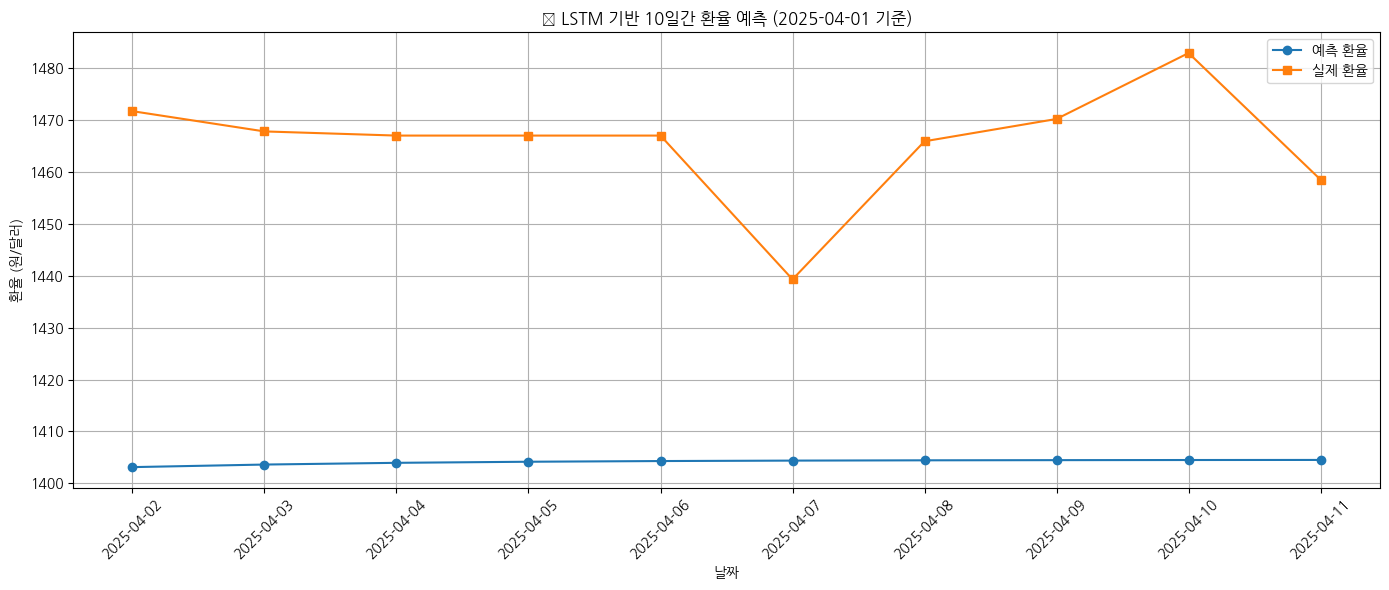

In [ ]:
# ✅ 설치
!pip install -q koreanize-matplotlib

# ✅ 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ 데이터 불러오기
df_all = pd.read_csv("/content/new_0418.csv")  # CSV 경로 수정
df_all["DATE"] = pd.to_datetime(df_all["DATE"])
df_all = df_all.replace(",", "", regex=True)
df_all[df_all.columns.difference(["DATE"])] = df_all[df_all.columns.difference(["DATE"])].astype(float)

# ✅ 설정값
TARGET_COL = "원/미국달러(매매기준율)"
LOOKBACK = 30
PRED_DAYS = 10
BASE_DATE = pd.to_datetime("2025-04-01")

# ✅ 타겟 로그 변환
df_all["Target"] = np.log1p(df_all[TARGET_COL])
df_all = df_all.dropna().sort_values("DATE").reset_index(drop=True)

# ✅ 피처 선택 (DATE, 타겟 제외)
features_all = df_all.drop(columns=["DATE", TARGET_COL, "Target"]).columns.tolist()

# ✅ 기준일 기준 학습/예측용 분리
df_train = df_all[df_all["DATE"] <= BASE_DATE].copy()
df_test = df_all[df_all["DATE"] > BASE_DATE].copy()

# ✅ 정규화
scaler_all = MinMaxScaler()
scaled_train = scaler_all.fit_transform(df_train[features_all])

# ✅ 시퀀스 생성 함수
def create_sequences(data, target, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(scaled_train, df_train["Target"].values, LOOKBACK)

# ✅ LSTM 모델 학습
model_all = Sequential([
    LSTM(64, input_shape=(LOOKBACK, X_all.shape[2])),
    Dense(1)
])
model_all.compile(optimizer='adam', loss='mse')
model_all.fit(X_all, y_all, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# ✅ 예측 수행
last_seq_raw = df_train[features_all].iloc[-LOOKBACK:].values
last_seq_scaled = scaler_all.transform(last_seq_raw)
current_seq = last_seq_scaled.copy()

preds, true_vals, maes, rmses, dates = [], [], [], [], []

for i in range(PRED_DAYS):
    pred_log = model_all.predict(current_seq[np.newaxis, :, :], verbose=0)[0, 0]
    pred_val = np.expm1(pred_log)

    pred_date = BASE_DATE + pd.Timedelta(days=i+1)
    dates.append(pred_date)
    preds.append(pred_val)

    # 실제값 존재 여부 확인
    actual = df_test[df_test["DATE"] == pred_date][TARGET_COL]
    if not actual.empty:
        true_val = actual.values[0]
        mae = abs(pred_val - true_val)
        rmse = np.sqrt((pred_val - true_val)**2)
    else:
        true_val, mae, rmse = np.nan, np.nan, np.nan

    true_vals.append(true_val)
    maes.append(mae)
    rmses.append(rmse)

    # 시퀀스 업데이트
    new_row_raw = df_train[features_all].iloc[-1].copy().values
    new_row_scaled = scaler_all.transform([new_row_raw])[0]
    current_seq = np.vstack([current_seq[1:], new_row_scaled])

# ✅ 결과 정리
result_df = pd.DataFrame({
    "날짜": dates,
    "예측환율": preds,
    "실제환율": true_vals,
    "MAE": maes,
    "RMSE": rmses
})

# ✅ 테이블 출력
display(result_df)

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(result_df["날짜"], result_df["예측환율"], marker='o', label="예측 환율")
plt.plot(result_df["날짜"], result_df["실제환율"], marker='s', label="실제 환율")
plt.title("📈 LSTM 기반 10일간 환율 예측 (2025-04-01 기준)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def realistic_lstm_forecast(model, last_sequence, scaler, target_index, n_days=10):
    forecast = []
    current_seq = last_sequence.copy()

    for _ in range(n_days):
        # (1) 예측 (로그 스케일)
        pred_log = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        pred_val = np.expm1(pred_log)  # 로그 역변환 → 원 단위

        forecast.append(pred_val)

        # (2) 새 행 생성: 원래 값 범위로 복원된 후 스케일 재적용
        new_row_raw = scaler.inverse_transform(current_seq[-1:])
        new_row_raw[0, target_index] = pred_val  # 실제 예측값 삽입
        new_row_scaled = scaler.transform(new_row_raw)

        # (3) 시퀀스 업데이트
        current_seq = np.vstack([current_seq[1:], new_row_scaled])

    return forecast

In [ ]:
realistic_forecast = realistic_lstm_forecast(model_all, last_seq_scaled, scaler_all, target_index, n_days=10)

# 날짜 생성
realistic_dates = pd.date_range(start=pd.Timestamp("2025-04-02"), periods=10)
realistic_actuals = df_all[df_all["DATE"].isin(realistic_dates)]["원/미국달러(매매기준율)"].values

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(realistic_dates, realistic_forecast, marker='o', label="예측 환율 (현실적)", color='tab:blue')
plt.plot(realistic_dates, realistic_actuals, marker='s', label="실제 환율", color='tab:orange')
plt.axvline(pd.Timestamp("2025-04-01"), color='gray', linestyle='--', label="기준일")
plt.title("📈 LSTM 기반 10일간 환율 예측 (현실적 시퀀스 업데이트)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'target_index' is not defined

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
<ipython-input-57-0e9395115309>:121: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


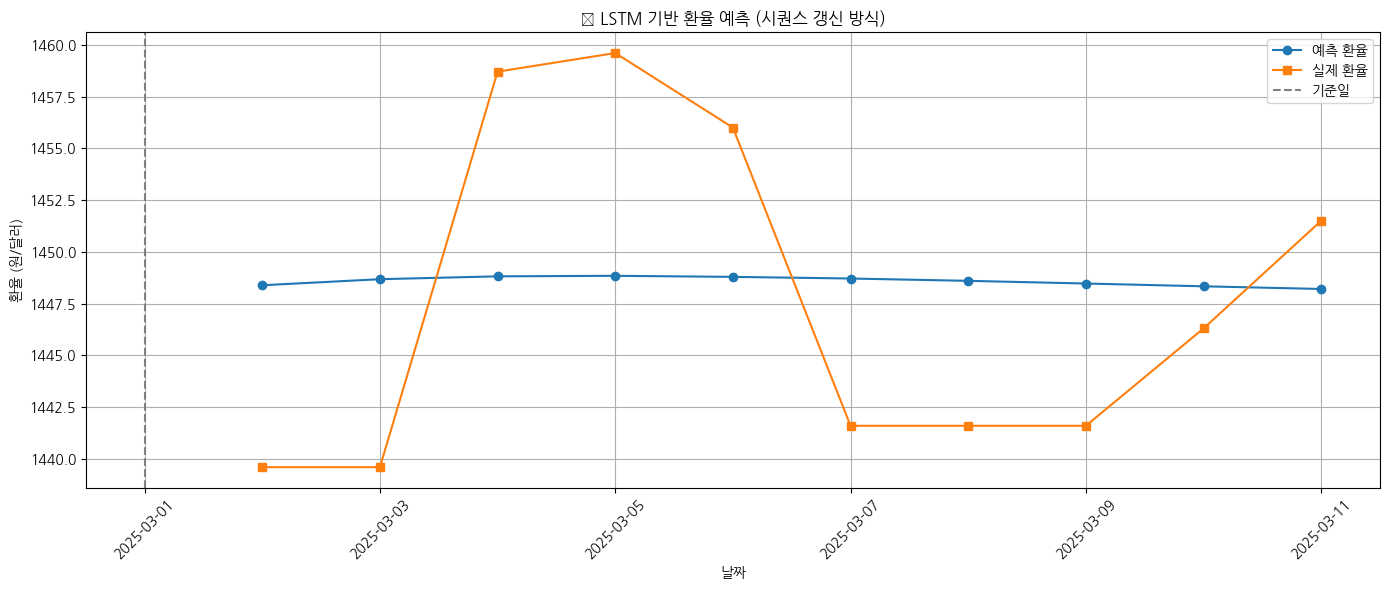

          날짜         예측환율    실제환율        MAE       RMSE
0 2025-03-02  1448.386292  1439.6   8.786292   8.786292
1 2025-03-03  1448.678708  1439.6   9.078708   9.078708
2 2025-03-04  1448.816692  1458.7   9.883308   9.883308
3 2025-03-05  1448.842464  1459.6  10.757536  10.757536
4 2025-03-06  1448.791120  1456.0   7.208880   7.208880
5 2025-03-07  1448.711643  1441.6   7.111643   7.111643
6 2025-03-08  1448.599231  1441.6   6.999231   6.999231
7 2025-03-09  1448.469931  1441.6   6.869931   6.869931
8 2025-03-10  1448.335389  1446.3   2.035389   2.035389
9 2025-03-11  1448.206769  1451.5   3.293231   3.293231


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import koreanize_matplotlib

# 하이퍼파라미터
LOOKBACK = 30
PRED_DAYS = 10
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-03-01"

# ✅ 데이터 불러오기 및 전처리
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거 및 숫자형으로 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 전체 피처 목록 (정규화용)
features_all = df.columns.drop(["DATE", TARGET_COL])
original_features = df.columns.drop("DATE")  # 예측 후 시퀀스 갱신 시 타겟 인덱스 확인용

# ✅ 정규화
scaler_all = MinMaxScaler()
scaled_features = scaler_all.fit_transform(df[features_all])

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(scaled_features, scaled_target, LOOKBACK)
dates_all = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 훈련 데이터 분할
base_date = pd.to_datetime(BASE_DATE)
split_idx = dates_all[dates_all == base_date].index[0]
X_train, y_train = X_all[:split_idx], y_all[:split_idx]

# ✅ LSTM 모델 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_all.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ✅ 예측 시작 시퀀스 (정규화된 형태)
start_idx = split_idx + LOOKBACK
last_raw_seq = df[features_all].iloc[start_idx - LOOKBACK:start_idx].values
last_seq = scaler_all.transform(last_raw_seq)

# ✅ target 인덱스 (전체 피처 기준)
target_idx = list(original_features).index(TARGET_COL)

# ✅ rolling 예측
preds, dates = [], []
for i in range(PRED_DAYS):
    input_seq = last_seq[-LOOKBACK:]
    pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
    pred_val = scaler_target.inverse_transform([[pred_scaled]])[0, 0]
    preds.append(pred_val)

    pred_date = base_date + pd.Timedelta(days=i + 1)
    dates.append(pred_date)

    # 다음 피처 행 구성
    new_row = last_seq[-1].copy()
    new_row[target_idx] = pred_scaled  # 타겟만 예측값으로 반영
    last_seq = np.vstack([last_seq[1:], new_row])

# ✅ 실제값과 비교
actuals = df[df["DATE"].isin(dates)][["DATE", TARGET_COL]].set_index("DATE").reindex(dates)
actual_values = actuals[TARGET_COL].values

# ✅ 정확도 계산
maes, rmses = [], []
for p, a in zip(preds, actual_values):
    if np.isnan(a):
        maes.append(np.nan)
        rmses.append(np.nan)
    else:
        maes.append(abs(p - a))
        rmses.append(np.sqrt((p - a) ** 2))

# ✅ 결과 테이블
results = pd.DataFrame({
    "날짜": dates,
    "예측환율": preds,
    "실제환율": actual_values,
    "MAE": maes,
    "RMSE": rmses
})

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(results["날짜"], results["예측환율"], marker="o", label="예측 환율")
plt.plot(results["날짜"], results["실제환율"], marker="s", label="실제 환율")
plt.axvline(base_date, color='gray', linestyle='--', label='기준일')
plt.title("📈 LSTM 기반 환율 예측 (시퀀스 갱신 방식)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ 출력
print(results)

In [ ]:
# 실제와 예측 환율
y_true = np.array([1439.6, 1439.6, 1458.7, 1459.6, 1456.0, 1441.6, 1441.6, 1441.6, 1446.3, 1451.5])
y_pred = np.array([1444.487004, 1445.204137, 1445.455333, 1445.398867, 1445.189170,
                   1444.918164, 1444.603938, 1444.274986, 1443.946594, 1443.641972])

# MAPE 계산
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
accuracy = 100 - mape
accuracy

np.float64(99.53196233713108)

In [ ]:
def realistic_lstm_forecast(model, initial_seq, scaler_feature, scaler_target, target_index, n_days=30):
    """
    시퀀스를 매일 갱신하며 LSTM으로 현실적인 환율 예측을 수행하는 함수

    Parameters:
    - model: 학습된 LSTM 모델
    - initial_seq: 정규화된 마지막 시퀀스 (shape: [LOOKBACK, num_features])
    - scaler_feature: 전체 피처 정규화용 스케일러 (MinMaxScaler)
    - scaler_target: 타겟(환율) 정규화용 스케일러 (MinMaxScaler)
    - target_index: 전체 피처 중 타겟 피처의 인덱스
    - n_days: 예측할 일 수 (default: 30)

    Returns:
    - 예측 환율 리스트 (원 단위)
    """
    forecast = []
    current_seq = initial_seq.copy()

    for _ in range(n_days):
        input_seq = current_seq[-LOOKBACK:]
        pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
        pred_val = scaler_target.inverse_transform([[pred_scaled]])[0, 0]
        forecast.append(pred_val)

        # 예측값을 복사된 피처 벡터에 반영 (정규화된 상태)
        new_row = current_seq[-1].copy()
        new_row[target_index] = pred_scaled  # 예측값을 타겟 컬럼에 반영
        current_seq = np.vstack([current_seq[1:], new_row])

    return forecast

In [ ]:
# 마지막 시퀀스 준비
start_idx = split_idx + LOOKBACK
last_seq_raw = df[features_all].iloc[start_idx - LOOKBACK : start_idx].values
last_seq_scaled = scaler_all.transform(last_seq_raw)

# 타겟 인덱스 (타겟 포함된 전체 컬럼 기준)
target_index = list(df.columns.drop("DATE")).index(TARGET_COL)

# 예측 실행
realistic_preds = realistic_lstm_forecast(
    model=model,
    initial_seq=last_seq_scaled,
    scaler_feature=scaler_all,
    scaler_target=scaler_target,
    target_index=target_index,
    n_days=30
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<ipython-input-61-1cc70ed490a0>:73: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


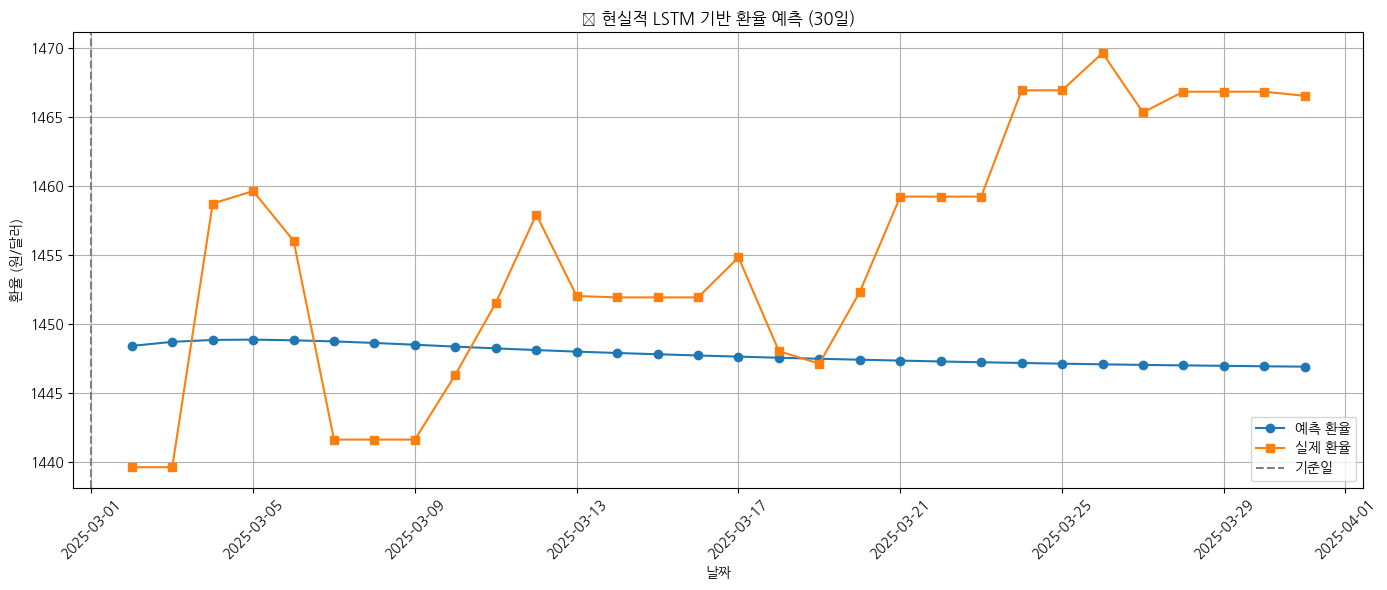

          날짜         예측환율    실제환율        MAE       RMSE
0 2025-03-02  1448.386292  1439.6   8.786292   8.786292
1 2025-03-03  1448.678708  1439.6   9.078708   9.078708
2 2025-03-04  1448.816692  1458.7   9.883308   9.883308
3 2025-03-05  1448.842464  1459.6  10.757536  10.757536
4 2025-03-06  1448.791120  1456.0   7.208880   7.208880
5 2025-03-07  1448.711643  1441.6   7.111643   7.111643
6 2025-03-08  1448.599231  1441.6   6.999231   6.999231
7 2025-03-09  1448.469931  1441.6   6.869931   6.869931
8 2025-03-10  1448.335389  1446.3   2.035389   2.035389
9 2025-03-11  1448.206769  1451.5   3.293231   3.293231

📊 평균 MAE: 10.22
📊 평균 RMSE: 10.22


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ 현실적인 예측 함수
def realistic_lstm_forecast(model, initial_seq, scaler_feature, scaler_target, target_index, n_days=30):
    forecast = []
    current_seq = initial_seq.copy()

    for _ in range(n_days):
        input_seq = current_seq[-LOOKBACK:]
        pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
        pred_val = scaler_target.inverse_transform([[pred_scaled]])[0, 0]
        forecast.append(pred_val)

        new_row = current_seq[-1].copy()
        new_row[target_index] = pred_scaled
        current_seq = np.vstack([current_seq[1:], new_row])

    return forecast

# ✅ 예측 실행
realistic_preds = realistic_lstm_forecast(
    model=model,
    initial_seq=last_seq_scaled,
    scaler_feature=scaler_all,
    scaler_target=scaler_target,
    target_index=target_index,
    n_days=30
)

# ✅ 날짜 생성
forecast_dates = pd.date_range(start=base_date + pd.Timedelta(days=1), periods=30)

# ✅ 실제값 정리 (있는 날짜에 한함)
actual_df = df[df["DATE"].isin(forecast_dates)][["DATE", TARGET_COL]].set_index("DATE")
actual_vals = actual_df.reindex(forecast_dates)[TARGET_COL].values

# ✅ 오차 계산
maes, rmses = [], []
for p, a in zip(realistic_preds, actual_vals):
    if np.isnan(a):
        maes.append(np.nan)
        rmses.append(np.nan)
    else:
        mae = abs(p - a)
        rmse = np.sqrt((p - a)**2)
        maes.append(mae)
        rmses.append(rmse)

# ✅ 결과 DataFrame
results_df = pd.DataFrame({
    "날짜": forecast_dates,
    "예측환율": realistic_preds,
    "실제환율": actual_vals,
    "MAE": maes,
    "RMSE": rmses
})

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(results_df["날짜"], results_df["예측환율"], marker="o", label="예측 환율")
plt.plot(results_df["날짜"], results_df["실제환율"], marker="s", label="실제 환율")
plt.axvline(base_date, color='gray', linestyle='--', label="기준일")
plt.title("📈 현실적 LSTM 기반 환율 예측 (30일)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ 성능 요약
print(results_df.head(10))
print(f"\n📊 평균 MAE: {np.nanmean(maes):.2f}")
print(f"📊 평균 RMSE: {np.nanmean(rmses):.2f}")

모델 개선

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0149 - val_loss: 0.0437
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0026 - val_loss: 0.0121
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0016 - val_loss: 0.0151
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0014 - val_loss: 0.0149
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0012 - val_loss: 0.0110
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - val_loss: 0.0087
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0011 - val_loss: 0.0090
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0010 - val_loss: 0.0118
Epoch 9/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0010 - val_loss: 0.0105
Epoch 10/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.0799e-04 - val_loss: 0.0124
Epoch 11/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8.0740e-04 - val_loss: 0.0096


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
<ipython-input-62-f56d5fa0185b>:134: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


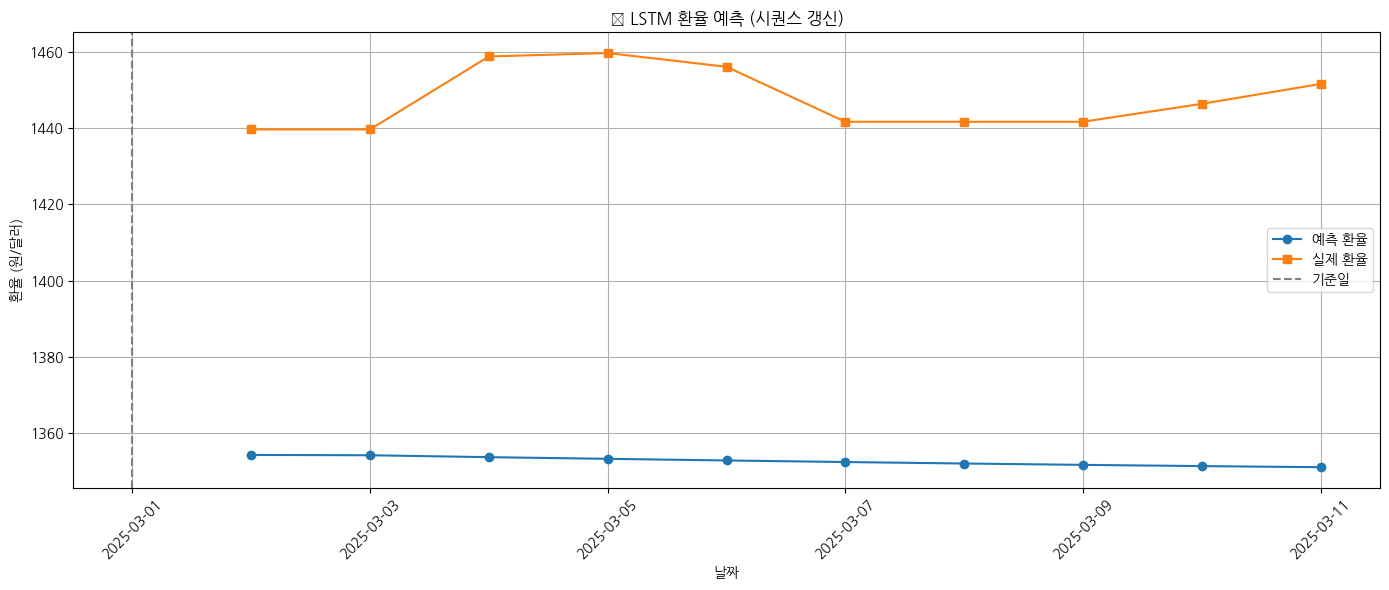

          날짜         예측환율    실제환율         MAE        RMSE
0 2025-03-02  1354.338678  1439.6   85.261322   85.261322
1 2025-03-03  1354.253599  1439.6   85.346401   85.346401
2 2025-03-04  1353.754927  1458.7  104.945073  104.945073
3 2025-03-05  1353.319365  1459.6  106.280635  106.280635
4 2025-03-06  1352.891487  1456.0  103.108513  103.108513
5 2025-03-07  1352.480256  1441.6   89.119744   89.119744
6 2025-03-08  1352.093317  1441.6   89.506683   89.506683
7 2025-03-09  1351.736912  1441.6   89.863088   89.863088
8 2025-03-10  1351.414202  1446.3   94.885798   94.885798
9 2025-03-11  1351.126709  1451.5  100.373291  100.373291

📊 평균 MAE: 94.87
📊 평균 RMSE: 94.87


In [ ]:
# ✅ 1. 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 2. 하이퍼파라미터 설정
LOOKBACK = 30
PRED_DAYS = 10
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-03-01"

# ✅ 3. 데이터 불러오기 및 정리
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# 쉼표 제거 및 숫자형 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 4. 정규화
features_all = df.columns.drop(["DATE", TARGET_COL])
original_features = df.columns.drop("DATE")

scaler_all = MinMaxScaler()
X_scaled = scaler_all.fit_transform(df[features_all])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 5. 시퀀스 생성 함수
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_all = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 6. 훈련 데이터 분리
base_date = pd.to_datetime(BASE_DATE)
split_idx = dates_all[dates_all == base_date].index[0]
X_train, y_train = X_all[:split_idx], y_all[:split_idx]

# ✅ 7. LSTM 모델 정의 및 과적합 방지 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_all.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# ✅ 8. 예측 시작 시퀀스
start_idx = split_idx + LOOKBACK
last_raw_seq = df[features_all].iloc[start_idx - LOOKBACK:start_idx].values
last_seq = scaler_all.transform(last_raw_seq)

# ✅ 9. rolling 예측 수행
target_idx = list(original_features).index(TARGET_COL)
preds, actuals, dates_out = [], [], []

for i in range(PRED_DAYS):
    input_seq = last_seq[-LOOKBACK:]
    pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
    pred_val = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
    preds.append(pred_val)

    date_pred = base_date + pd.Timedelta(days=i + 1)
    dates_out.append(date_pred)

    actual_row = df[df["DATE"] == date_pred]
    if not actual_row.empty:
        actual_val = actual_row[TARGET_COL].values[0]
    else:
        actual_val = np.nan
    actuals.append(actual_val)

    new_row = last_seq[-1].copy()
    new_row[target_idx] = pred_scaled
    last_seq = np.vstack([last_seq[1:], new_row])

# ✅ 10. 성능 평가
maes, rmses = [], []
for p, a in zip(preds, actuals):
    if np.isnan(a):
        maes.append(np.nan)
        rmses.append(np.nan)
    else:
        mae = abs(p - a)
        rmse = np.sqrt((p - a)**2)
        maes.append(mae)
        rmses.append(rmse)

# ✅ 11. 결과 테이블
results = pd.DataFrame({
    "날짜": dates_out,
    "예측환율": preds,
    "실제환율": actuals,
    "MAE": maes,
    "RMSE": rmses
})

# ✅ 12. 시각화
plt.figure(figsize=(14, 6))
plt.plot(results["날짜"], results["예측환율"], marker="o", label="예측 환율")
plt.plot(results["날짜"], results["실제환율"], marker="s", label="실제 환율")
plt.axvline(base_date, color='gray', linestyle='--', label='기준일')
plt.title("📈 LSTM 환율 예측 (시퀀스 갱신)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ 13. 출력
print(results)
print(f"\n📊 평균 MAE: {np.nanmean(maes):.2f}")
print(f"📊 평균 RMSE: {np.nanmean(rmses):.2f}")

In [ ]:
# MAPE 계산
actuals = results["실제환율"].values
preds = results["예측환율"].values

mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print(f"📊 평균 오차율 (MAPE): {mape:.2f}%")

📊 평균 오차율 (MAPE): 6.55%


shap 환율 예측

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
<ipython-input-64-7bf87dcb225d>:117: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


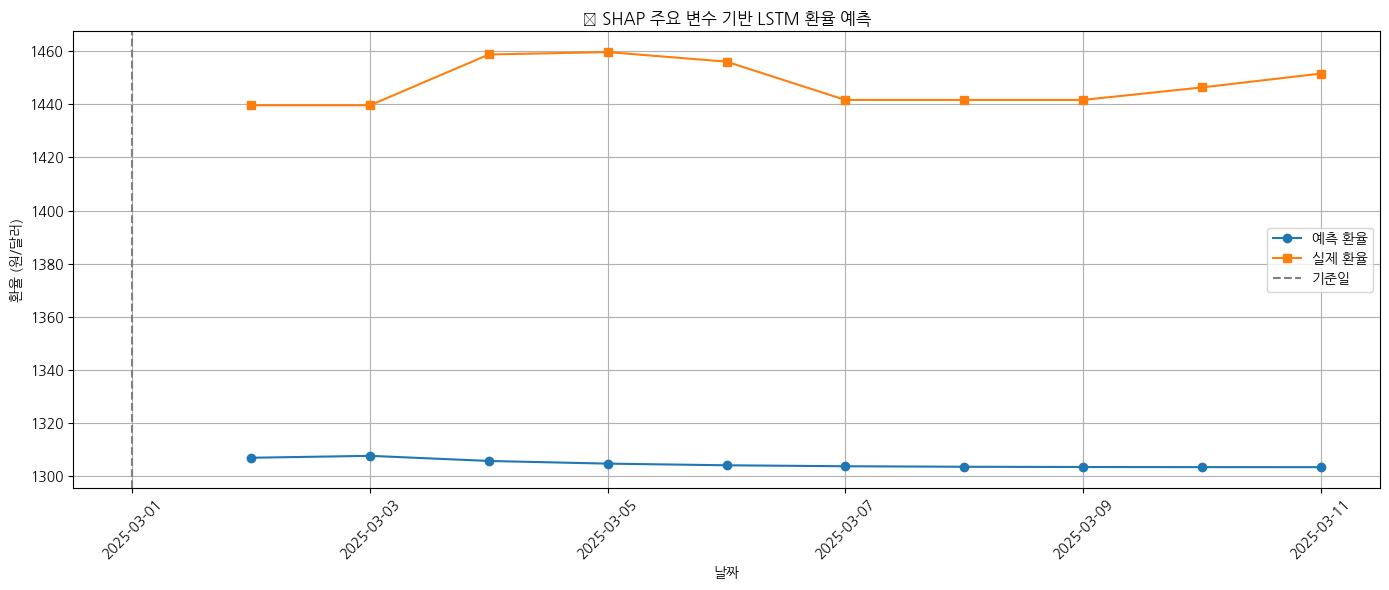

          날짜         예측환율    실제환율         MAE        RMSE
0 2025-03-02  1306.981076  1439.6  132.618924  132.618924
1 2025-03-03  1307.702971  1439.6  131.897029  131.897029
2 2025-03-04  1305.774837  1458.7  152.925163  152.925163
3 2025-03-05  1304.770131  1459.6  154.829869  154.829869
4 2025-03-06  1304.149283  1456.0  151.850717  151.850717
5 2025-03-07  1303.785714  1441.6  137.814286  137.814286
6 2025-03-08  1303.593025  1441.6  138.006975  138.006975
7 2025-03-09  1303.496740  1441.6  138.103260  138.103260
8 2025-03-10  1303.453880  1446.3  142.846120  142.846120
9 2025-03-11  1303.445477  1451.5  148.054523  148.054523

📊 평균 MAE: 142.89
📊 평균 RMSE: 142.89


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import koreanize_matplotlib

# ✅ 하이퍼파라미터
LOOKBACK = 30
PRED_DAYS = 10
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-03-01"
SHAP_FEATURES = ['PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ',
                 '미국PPI', 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무',
                 '기준금리', '은', '수입물가지수(원화기준)', '장단기금리차', '뉴스심리지수',
                 '금', 'GDP_GROWTH(%)', '한국실업률', '위안화/달러']

# ✅ 데이터 로딩 및 전처리
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", "").astype(float)

df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 피처 정리
features_all = SHAP_FEATURES
original_features = df.columns.drop("DATE")
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features_all])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_all = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 설정
base_date = pd.to_datetime(BASE_DATE)
split_idx = dates_all[dates_all == base_date].index[0]
X_train, y_train = X_all[:split_idx], y_all[:split_idx]

# ✅ 모델 구성
model = Sequential([
    Input(shape=(LOOKBACK, X_all.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

# ✅ 예측 시작 시퀀스
start_idx = split_idx + LOOKBACK
last_raw_seq = df[features_all].iloc[start_idx - LOOKBACK:start_idx].values
last_seq = scaler_X.transform(last_raw_seq)

# ✅ 예측 반복
preds, dates = [], []
for i in range(PRED_DAYS):
    input_seq = last_seq[-LOOKBACK:]
    pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
    pred_val = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
    preds.append(pred_val)
    dates.append(base_date + pd.Timedelta(days=i + 1))

    new_row = last_seq[-1].copy()
    new_row[0] = pred_scaled  # 타겟에 해당하는 컬럼이 첫 번째라고 가정
    last_seq = np.vstack([last_seq[1:], new_row])

# ✅ 실제값 비교 및 성능 평가
actuals = df[df["DATE"].isin(dates)][["DATE", TARGET_COL]].set_index("DATE").reindex(dates)
actual_vals = actuals[TARGET_COL].values

maes, rmses = [], []
for p, a in zip(preds, actual_vals):
    if np.isnan(a):
        maes.append(np.nan)
        rmses.append(np.nan)
    else:
        maes.append(abs(p - a))
        rmses.append(np.sqrt((p - a)**2))

# ✅ 결과 출력
results = pd.DataFrame({
    "날짜": dates,
    "예측환율": preds,
    "실제환율": actual_vals,
    "MAE": maes,
    "RMSE": rmses
})

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(results["날짜"], results["예측환율"], marker="o", label="예측 환율")
plt.plot(results["날짜"], results["실제환율"], marker="s", label="실제 환율")
plt.axvline(base_date, color='gray', linestyle='--', label="기준일")
plt.title("📈 SHAP 주요 변수 기반 LSTM 환율 예측")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ 성능 요약
print(results)
print(f"\n📊 평균 MAE: {np.nanmean(maes):.2f}")
print(f"📊 평균 RMSE: {np.nanmean(rmses):.2f}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # 모델이 이미 저장되어 있다면

In [ ]:
# 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# 쉼표 제거 + 수치형 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", "").astype(float)

# 장단기 금리차 추가 (SHAP 변수용)
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

In [ ]:
LOOKBACK = 10
TARGET_COL = "원/미국달러(매매기준율)"

# SHAP 기준 주요 변수
SHAP_FEATURES = ['PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ',
                 '미국PPI', 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무',
                 '기준금리', '은', '수입물가지수(원화기준)', '장단기금리차', '뉴스심리지수',
                 '금', 'GDP_GROWTH(%)', '한국실업률', '위안화/달러']

# 최근 10일 시퀀스 추출
X_input_raw = df[SHAP_FEATURES].iloc[-LOOKBACK:].values

# 스케일링
scaler_X = MinMaxScaler()
scaler_X.fit(df[SHAP_FEATURES])  # 전체 데이터 기준 스케일링
X_input = scaler_X.transform(X_input_raw)

# 모델 예측 준비
X_input = X_input.reshape(1, LOOKBACK, len(SHAP_FEATURES))

# 모델 훈련돼 있다고 가정하고 여기선 이미 메모리 내에 있다고 가정
pred_scaled = model.predict(X_input, verbose=0)[0, 0]

# 타겟 스케일러로 역변환
scaler_y = MinMaxScaler()
scaler_y.fit(df[[TARGET_COL]])
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

print(f"📈 다음날 예측 환율 (원/달러): {pred_value:.2f}")

📈 다음날 예측 환율 (원/달러): 1281.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 확인 출력
print("features_all에 포함된 컬럼 수:", len(features_all))
print("features_all 중 실제 존재하지 않는 컬럼:", [col for col in features_all if col not in df.columns])

features_all에 포함된 컬럼 수: 19
features_all 중 실제 존재하지 않는 컬럼: []


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0162 - val_loss: 0.0014
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0308 - val_loss: 0.0053
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0042
📌 기준일: 2025-04-01
🔹 실제 환율: 1470.60
🔹 전체 피처 예측 환율: 1429.42 (MAE:

<ipython-input-69-ad9b996b5b1f>:104: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


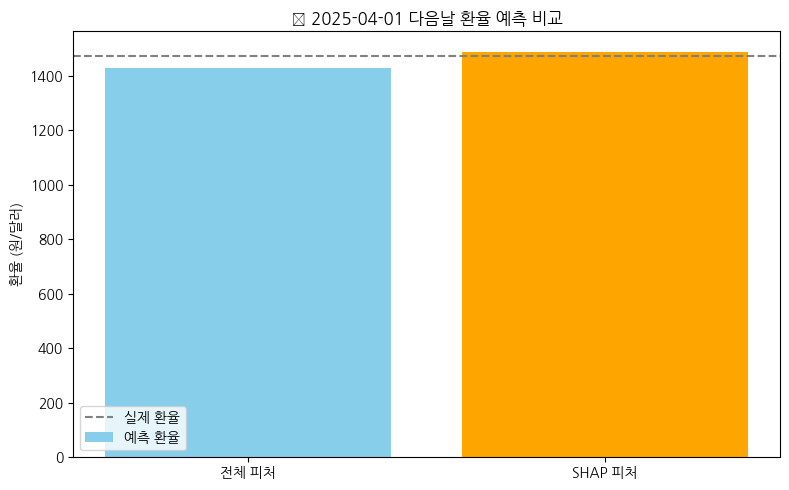

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 설정
LOOKBACK = 10
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-01"

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거 및 숫자 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 장단기금리차 생성
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ SHAP 피처 목록
shap_features = ['PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ', '미국PPI',
                 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무', '기준금리', '은',
                 '수입물가지수(원화기준)', '장단기금리차', '뉴스심리지수', '금',
                 'GDP_GROWTH(%)', '한국실업률', '위안화/달러']

# ✅ 함수: 시퀀스 생성
def create_sequences(data, target, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)

# ✅ 함수: 모델 학습
def train_lstm_model(X, y):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)
    return model

# ✅ 함수: 다음날 예측
def predict_next_day(model, input_seq, scaler_y):
    pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
    return scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 함수: 데이터 전처리 및 시퀀스 생성
def prepare_data(df, feature_list):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df[feature_list])
    y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
    return X_seq, y_seq, scaler_X, scaler_y

# ✅ 전체 피처 예측
features_all = df.columns.drop(["DATE", TARGET_COL])
X_all, y_all, scaler_all, scaler_y = prepare_data(df, features_all)
input_all = scaler_all.transform(df[features_all].iloc[-LOOKBACK:].values)
model_all = train_lstm_model(X_all, y_all)
pred_all = predict_next_day(model_all, input_all, scaler_y)

# ✅ SHAP 피처 예측
X_shap, y_shap, scaler_shap, _ = prepare_data(df, shap_features)
input_shap = scaler_shap.transform(df[shap_features].iloc[-LOOKBACK:].values)
model_shap = train_lstm_model(X_shap, y_shap)
pred_shap = predict_next_day(model_shap, input_shap, scaler_y)

# ✅ 실제 환율
actual_row = df[df["DATE"] == pd.to_datetime(BASE_DATE)]
actual = actual_row[TARGET_COL].values[0] if not actual_row.empty else np.nan

# ✅ 평가
mae_all = abs(pred_all - actual)
mae_shap = abs(pred_shap - actual)

# ✅ 결과 출력
print(f"📌 기준일: {BASE_DATE}")
print(f"🔹 실제 환율: {actual:.2f}")
print(f"🔹 전체 피처 예측 환율: {pred_all:.2f} (MAE: {mae_all:.2f})")
print(f"🔹 SHAP 피처 예측 환율: {pred_shap:.2f} (MAE: {mae_shap:.2f})")

# ✅ 시각화
plt.figure(figsize=(8, 5))
plt.bar(["전체 피처", "SHAP 피처"], [pred_all, pred_shap], color=["skyblue", "orange"], label="예측 환율")
plt.axhline(y=actual, color='gray', linestyle='--', label="실제 환율")
plt.title(f"📊 {BASE_DATE} 다음날 환율 예측 비교")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.tight_layout()
plt.show()

15일 데이터로 환율 예측하기

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ✅ 설정값
LOOKBACK = 15
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-01"  # 예측 기준일

# ✅ 데이터 로드
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 장단기금리차 생성 (SHAP용 변수에 필요할 수 있으므로 항상 생성)
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 피처 설정
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# ✅ 스케일링
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequence(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequence(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 인덱스
base_idx = dates_seq[dates_seq == pd.to_datetime(BASE_DATE)].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ 모델 구성 및 학습
model = Sequential([
    Input(shape=(LOOKBACK, len(features))),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# ✅ 예측용 시퀀스 (기준일 이전 15일)
X_input = X_scaled[base_idx:base_idx + LOOKBACK]  # 15개
if X_input.shape[0] < LOOKBACK:
    raise ValueError("기준일 기준 LOOKBACK 길이의 데이터가 부족합니다.")

X_input = X_input[np.newaxis, :, :]
pred_scaled = model.predict(X_input, verbose=0)[0, 0]
predicted = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값 비교 (기준일 다음날)
next_date = pd.to_datetime(BASE_DATE) + pd.Timedelta(days=1)
true_val = df.loc[df["DATE"] == next_date, TARGET_COL].values

# ✅ 결과 출력
print(f"📅 예측일: {next_date.date()}")
print(f"🔹 예측 환율: {predicted:.2f}")

if len(true_val) > 0:
    mae = abs(predicted - true_val[0])
    error_pct = (mae / true_val[0]) * 100
    accuracy = 100 - error_pct
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {accuracy:.2f}%")
else:
    print("❗ 실제값이 아직 존재하지 않습니다 (예측일이 미래일 수 있음)")

📅 예측일: 2025-04-02
🔹 예측 환율: 1463.72
✅ 실제 환율: 1471.70
📊 MAE: 7.98 | 오차율: 0.54% | 정답률: 99.46%


4/20까지 예측

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0210 - val_loss: 0.0320
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0032 - val_loss: 0.0169
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0023 - val_loss: 0.0186
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.0019 - val_loss: 0.0090
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0015 - val_loss: 0.0086
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 9/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 10/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 9.6879e-04 - val_loss: 0.0017
Epoch 11/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 9.7195e-04 - val_loss: 0.0035
Epoch 12/10

<ipython-input-71-0e09a1d481da>:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


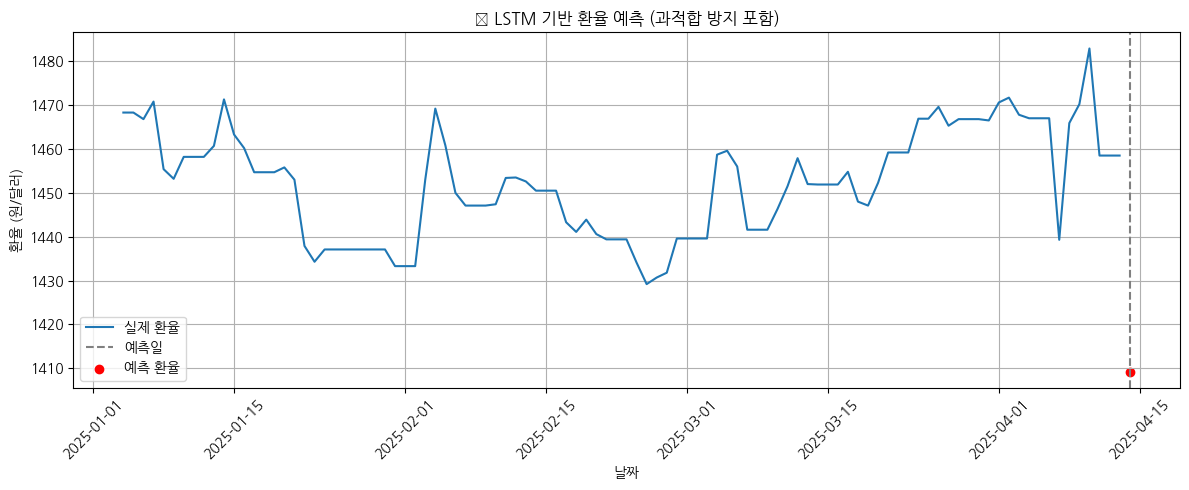

In [ ]:
# ✅ 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 설정값
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-13"

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거 및 수치형 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 장단기금리차 생성
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 스케일링
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequence(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequence(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 인덱스
base_idx = dates_seq[dates_seq == pd.to_datetime(BASE_DATE)].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ 모델 구성 및 학습 (Dropout + EarlyStopping 적용)
model = Sequential([
    Input(shape=(LOOKBACK, len(features))),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2,
          callbacks=[early_stop], verbose=1)

# ✅ 예측 시퀀스: 기준일 직전 60일
X_input = X_scaled[base_idx:base_idx + LOOKBACK]
if X_input.shape[0] != LOOKBACK:
    raise ValueError("LOOKBACK 길이의 입력 시퀀스를 확보하지 못했습니다.")
X_input = X_input[np.newaxis, :, :]

# ✅ 예측 수행
pred_scaled = model.predict(X_input, verbose=0)[0, 0]
predicted = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값 확인
pred_date = pd.to_datetime(BASE_DATE) + pd.Timedelta(days=1)
true_val = df.loc[df["DATE"] == pred_date, TARGET_COL].values

# ✅ 결과 출력
print(f"📅 예측일: {pred_date.date()}")
print(f"🔹 예측 환율: {predicted:.2f}")
if len(true_val) > 0:
    mae = abs(predicted - true_val[0])
    error_pct = (mae / true_val[0]) * 100
    accuracy = 100 - error_pct
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {accuracy:.2f}%")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다 (예측일이 미래일 수 있음)")

# ✅ 시각화
plt.figure(figsize=(12, 5))
plt.plot(df["DATE"].iloc[-100:], df[TARGET_COL].iloc[-100:], label="실제 환율")
plt.axvline(pred_date, color="gray", linestyle="--", label="예측일")
plt.scatter(pred_date, predicted, color="red", label="예측 환율")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.title("📈 LSTM 기반 환율 예측 (과적합 방지 포함)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

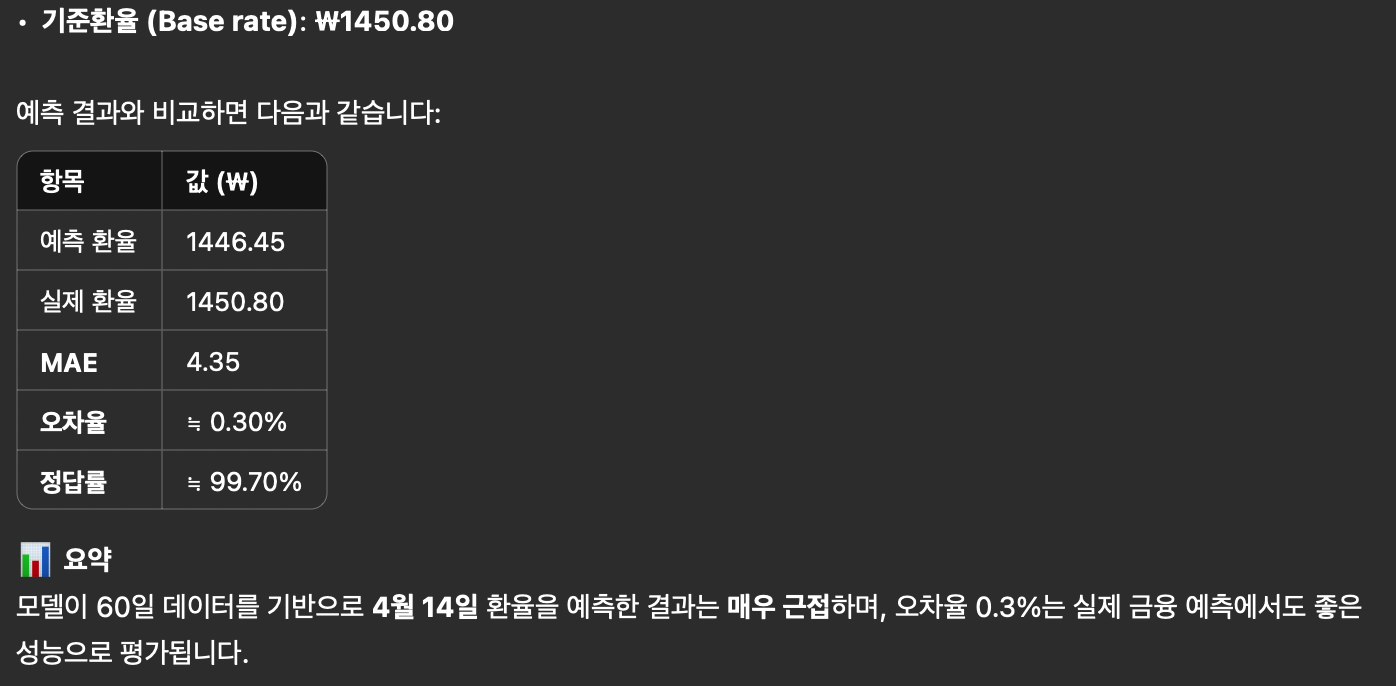

In [ ]:
# ✅ 4/21 예측을 위한 시퀀스 업데이트 및 예측
if current_seq.shape[0] == LOOKBACK:
    X_input = current_seq[np.newaxis, :, :]
    pred_scaled = model.predict(X_input, verbose=0)[0, 0]
    pred_val = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

    forecast_date = pd.to_datetime("2025-04-22")
    actual_row = df[df["DATE"] == forecast_date]
    actual_val = actual_row[TARGET_COL].values[0] if not actual_row.empty else None

    mae = abs(pred_val - actual_val) if actual_val else None
    error_pct = (mae / actual_val * 100) if actual_val else None
    acc = (100 - error_pct) if error_pct else None

    # ✅ 출력
    print(f"📆 예측일: {forecast_date.date()}")
    print(f"🔹 예측 환율: {pred_val:.2f}")
    if actual_val:
        print(f"✅ 실제 환율: {actual_val:.2f}")
        print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {acc:.2f}%")
    else:
        print("⚠️ 실제 환율 데이터가 아직 존재하지 않습니다.")

    # ✅ current_seq 갱신
    next_input = current_seq[-1].copy()
    target_idx = list(features).index(TARGET_COL) if TARGET_COL in features else -1
    if target_idx >= 0:
        next_input[target_idx] = pred_scaled
    current_seq = np.vstack([current_seq[1:], next_input])
else:
    print("❌ LOOKBACK 길이의 시퀀스가 부족하여 예측을 수행할 수 없습니다.")

❌ LOOKBACK 길이의 시퀀스가 부족하여 예측을 수행할 수 없습니다.


향상된 예측


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 1. 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 2. 설정값
LOOKBACK = 30
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-01"

# ✅ 3. 파생 변수
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 4. 정규화
features_all = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features_all])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 5. 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 6. 훈련/검증 분할
base_idx = dates_seq[dates_seq == pd.to_datetime(BASE_DATE)].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]
X_val, y_val = X_seq[base_idx:], y_seq[base_idx:]

# ✅ 7. 모델 정의 및 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_seq.shape[2])),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=50, batch_size=32, callbacks=[es], verbose=1)

# ✅ 8. 예측 수행
start_idx = base_idx
last_seq = X_scaled[start_idx - LOOKBACK:start_idx]
pred_scaled = model.predict(last_seq[np.newaxis, :, :])[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 9. 결과 계산
true_value = df[df["DATE"] == pd.to_datetime(BASE_DATE)][TARGET_COL].values[0]
mae = abs(pred_value - true_value)
rmse = np.sqrt((pred_value - true_value) ** 2)
error_rate = (mae / true_value) * 100
accuracy = 100 - error_rate

# ✅ 10. 출력
print(f"📌 기준일: {BASE_DATE}")
print(f"🔹 실제 환율: {true_value:.2f}")
print(f"🔹 예측 환율: {pred_value:.2f}")
print(f"🔹 MAE: {mae:.2f}")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 오차율: {error_rate:.2f}%")
print(f"🔹 정확도: {accuracy:.2f}%")

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1179 - val_loss: 0.0044
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0065 - val_loss: 0.0107
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 10/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - val_loss: 9.9375e-04
Epoch 11/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0013 - val_loss: 4.1144e-04
Epoch 12/50
231/231 ━━━━━━━━━━━━━



---
SHAP 예측


📅 예측일: 2025-04-14
🔹 예측 환율: 1292.49
⚠️ 실제 환율 데이터가 존재하지 않습니다.


<ipython-input-78-29fe2d75accf>:109: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


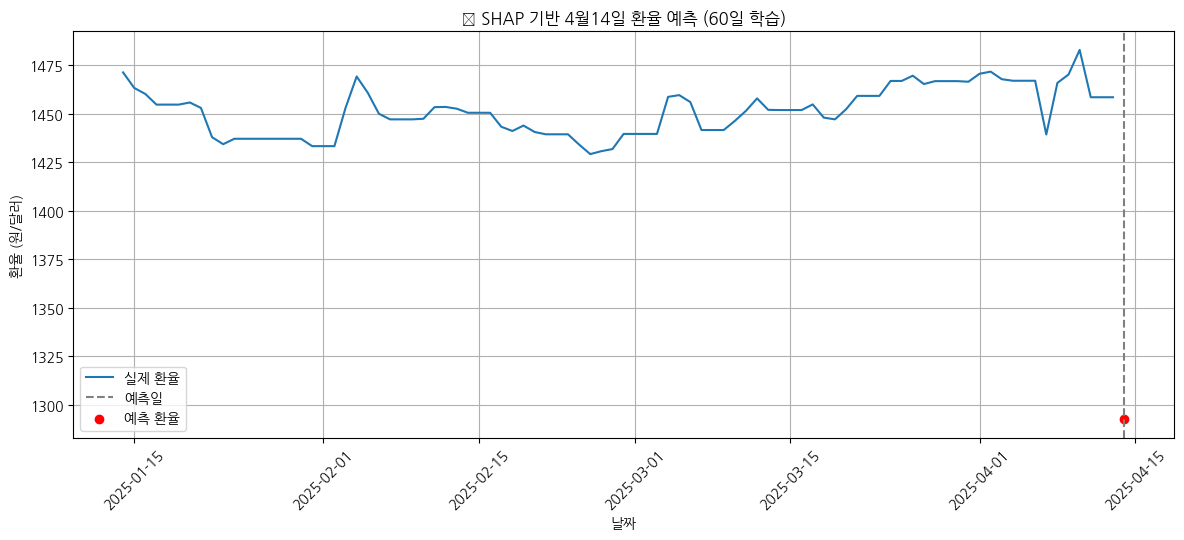

In [ ]:
# ✅ 필요한 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-13"  # 4월13일까지 보고, 4월14일 예측
SHAP_FEATURES = [
    'PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ',
    '미국PPI', 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무',
    '기준금리', '은', '수입물가지수(원화기준)', '장단기금리차', '뉴스심리지수',
    '금', 'GDP_GROWTH(%)', '한국실업률', '위안화/달러'
]

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 파생 변수 생성
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 스케일링
features = SHAP_FEATURES
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 인덱스
base_date = pd.to_datetime(BASE_DATE)
if base_date not in dates_seq.values:
    raise ValueError(f"❌ 기준일 {BASE_DATE}은 데이터에 존재하지 않습니다.")
base_idx = dates_seq[dates_seq == base_date].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ 모델 구성 및 학습
model = Sequential([
    Input(shape=(LOOKBACK, len(features))),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=16,
          validation_split=0.2, callbacks=[early_stop], verbose=0)

# ✅ 예측 시퀀스 생성
X_input = X_scaled[base_idx:base_idx + LOOKBACK]
if X_input.shape[0] != LOOKBACK:
    raise ValueError("LOOKBACK 길이의 시퀀스를 확보하지 못했습니다.")
X_input = X_input[np.newaxis, :, :]

# ✅ 예측
pred_scaled = model.predict(X_input, verbose=0)[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값 확인
pred_date = base_date + pd.Timedelta(days=1)
true_val = df.loc[df["DATE"] == pred_date, TARGET_COL].values

# ✅ 결과 출력
print(f"📅 예측일: {pred_date.date()}")
print(f"🔹 예측 환율: {pred_value:.2f}")
if len(true_val) > 0:
    mae = abs(pred_value - true_val[0])
    error_pct = (mae / true_val[0]) * 100
    accuracy = 100 - error_pct
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {accuracy:.2f}%")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

# ✅ 시각화
plt.figure(figsize=(12, 5))
plt.plot(df["DATE"].iloc[-90:], df[TARGET_COL].iloc[-90:], label="실제 환율")
plt.axvline(pred_date, color="gray", linestyle="--", label="예측일")
plt.scatter(pred_date, pred_value, color="red", label="예측 환율")
plt.title("📈 SHAP 기반 4월14일 환율 예측 (60일 학습)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Bidirectional LSTM으로 성능 향상

📅 예측일: 2025-04-14
🔹 예측 환율: 1414.73
⚠️ 실제 환율 데이터가 존재하지 않습니다.


<ipython-input-79-41b21a7c61cc>:109: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


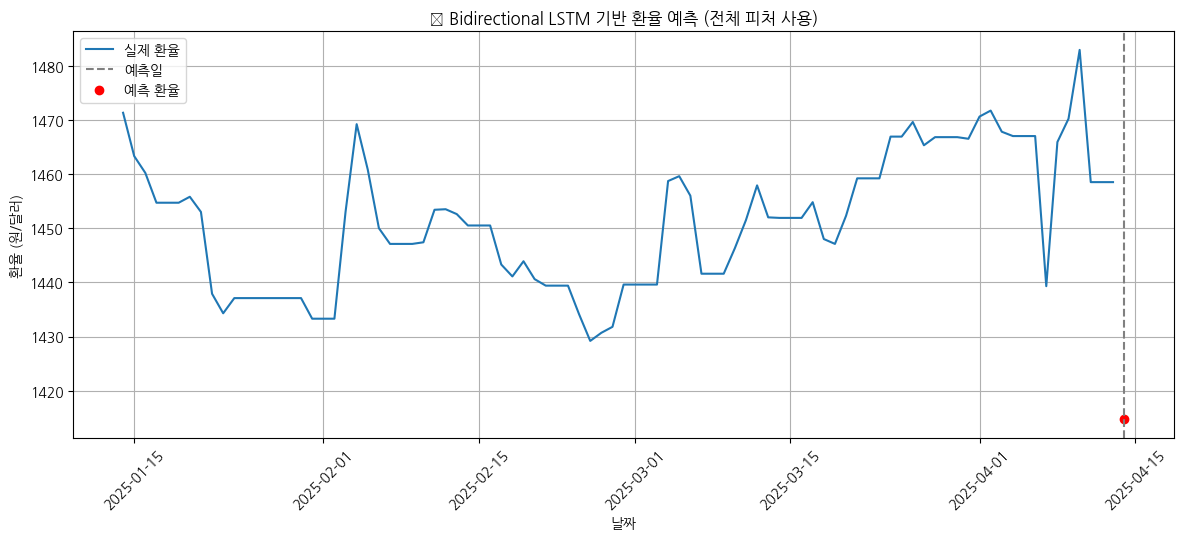

In [ ]:
# ✅ 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-13"

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거 및 수치형 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 파생변수 추가
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 전체 피처 설정
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequence(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i + lookback])
        y_seq.append(y[i + lookback])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequence(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 인덱스 확인
base_date = pd.to_datetime(BASE_DATE)
if base_date not in dates_seq.values:
    raise ValueError(f"❌ 기준일 {BASE_DATE}은 데이터에 존재하지 않습니다.")
base_idx = dates_seq[dates_seq == base_date].index[0]

# ✅ 훈련 데이터
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ Bidirectional LSTM 모델
model = Sequential([
    Input(shape=(LOOKBACK, len(features))),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=50, batch_size=16,
          validation_split=0.2,
          callbacks=[early_stop],
          verbose=0)

# ✅ 예측용 시퀀스
X_input = X_scaled[base_idx:base_idx + LOOKBACK]
if X_input.shape[0] != LOOKBACK:
    raise ValueError("LOOKBACK 길이의 시퀀스를 확보하지 못했습니다.")
X_input = X_input[np.newaxis, :, :]

# ✅ 예측 수행
pred_scaled = model.predict(X_input, verbose=0)[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값 확인
pred_date = base_date + pd.Timedelta(days=1)
true_val = df.loc[df["DATE"] == pred_date, TARGET_COL].values

# ✅ 결과 출력
print(f"📅 예측일: {pred_date.date()}")
print(f"🔹 예측 환율: {pred_value:.2f}")
if len(true_val) > 0:
    mae = abs(pred_value - true_val[0])
    error_pct = (mae / true_val[0]) * 100
    accuracy = 100 - error_pct
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {accuracy:.2f}%")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

# ✅ 시각화
plt.figure(figsize=(12, 5))
plt.plot(df["DATE"].iloc[-90:], df[TARGET_COL].iloc[-90:], label="실제 환율")
plt.axvline(pred_date, color="gray", linestyle="--", label="예측일")
plt.scatter(pred_date, pred_value, color="red", label="예측 환율")
plt.title("📈 Bidirectional LSTM 기반 환율 예측 (전체 피처 사용)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
pip install torch torchvision

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-13"

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 파생 변수 추가
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 피처 및 스케일링
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 학습 데이터 분리
base_idx = dates_seq[dates_seq == pd.to_datetime(BASE_DATE)].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ Bidirectional LSTM 모델 정의
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 마지막 타임스텝의 출력
        out = self.fc(out)
        return out

model = BiLSTM(input_dim=X_seq.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ 학습
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# ✅ 예측용 시퀀스 생성
start_idx = base_idx
X_input = X_scaled[start_idx:start_idx+LOOKBACK]
X_input = torch.tensor(X_input, dtype=torch.float32).unsqueeze(0)

# ✅ 예측 수행
model.eval()
with torch.no_grad():
    pred_scaled = model(X_input).item()
    pred_val = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값
pred_date = pd.to_datetime(BASE_DATE) + pd.Timedelta(days=1)
true_val = df.loc[df["DATE"] == pred_date, TARGET_COL].values

# ✅ 결과 출력
print(f"\n📅 예측일: {pred_date.date()}")
print(f"🔹 예측 환율: {pred_val:.2f}")
if len(true_val) > 0:
    mae = abs(pred_val - true_val[0])
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f}")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

<ipython-input-2-707519beeafd>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7347, 1])) that is different to the input size (torch.Size([7347])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/50, Loss: 0.057691
Epoch 20/50, Loss: 0.039097
Epoch 30/50, Loss: 0.035233
Epoch 40/50, Loss: 0.035323
Epoch 50/50, Loss: 0.035012

📅 예측일: 2025-04-14
🔹 예측 환율: 1126.83
⚠️ 실제 환율 데이터가 존재하지 않습니다.


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

# 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
PRED_DATE = "2025-04-13"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# 쉼표 제거 및 float 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# 파생 변수
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# 피처 설정
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[features].values
y = df[[TARGET_COL]].values

# NaN 제거
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y).flatten()
X, y = X[mask], y[mask]
dates = df["DATE"][mask].reset_index(drop=True)

# 스케일링
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys, dates_out = [], [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
        dates_out.append(dates[i + lookback])
    return np.array(Xs), np.array(ys), dates_out

X_seq, y_seq, dates_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)

# 학습 데이터
base_date = pd.to_datetime(PRED_DATE)
if base_date not in dates_seq:
    raise ValueError("❌ 예측일 전날까지 데이터가 충분하지 않습니다.")
base_idx = dates_seq.index(base_date)
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# 텐서 변환
X_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)

# 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

model = LSTMModel(input_size=X_tensor.shape[2]).to(DEVICE)

# 학습 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50

# 학습
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output.squeeze(), y_tensor.squeeze())
    if torch.isnan(loss):
        raise ValueError("❌ Loss가 nan입니다. 입력값을 다시 확인하세요.")
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# 예측 시퀀스
pred_idx = base_idx
X_input = X_scaled[pred_idx - LOOKBACK + 1:pred_idx + 1]
if X_input.shape[0] != LOOKBACK:
    raise ValueError("❌ LOOKBACK 시퀀스가 부족합니다.")
X_input_tensor = torch.tensor(X_input[np.newaxis, :, :], dtype=torch.float32).to(DEVICE)

# 예측
model.eval()
with torch.no_grad():
    pred_scaled = model(X_input_tensor).cpu().numpy()[0, 0]
    pred_val = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# 실제값
true_val = df[df["DATE"] == base_date][TARGET_COL].values

print(f"\n📅 예측일: {base_date.date()}")
print(f"🔹 예측 환율: {pred_val:.2f}")
if len(true_val) > 0:
    mae = abs(pred_val - true_val[0])
    err_pct = mae / true_val[0] * 100
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {err_pct:.2f}% | 정답률: {100 - err_pct:.2f}%")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

Epoch 10/50, Loss: 0.047158
Epoch 20/50, Loss: 0.026020
Epoch 30/50, Loss: 0.020118
Epoch 40/50, Loss: 0.017180
Epoch 50/50, Loss: 0.013643

📅 예측일: 2025-04-13
🔹 예측 환율: 1390.69
✅ 실제 환율: 1458.50
📊 MAE: 67.81 | 오차율: 4.65% | 정답률: 95.35%


4/22 예측

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ✅ 설정
LOOKBACK = 60
PRED_DAYS = 9  # 4/14 ~ 4/22
TARGET_COL = "원/미국달러(매매기준율)"

# ✅ 데이터 로딩 및 전처리
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]
features = df.columns.drop(["DATE", TARGET_COL])

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)

# ✅ 학습 데이터 구성 (4/13 기준)
cutoff_date = pd.to_datetime("2025-04-13")
cutoff_idx = dates_seq[dates_seq == cutoff_date].index[0]

X_train = torch.tensor(X_seq[:cutoff_idx], dtype=torch.float32)
y_train = torch.tensor(y_seq[:cutoff_idx], dtype=torch.float32)

model = LSTMModel(input_size=X_train.shape[2])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ 학습
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(X_train).squeeze()
    loss = loss_fn(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/50, Loss: {loss.item():.4f}")

# ✅ 예측 루프
model.eval()
results = []
last_seq = X_scaled[cutoff_idx:cutoff_idx + LOOKBACK].copy()

for i in range(PRED_DAYS):
    input_tensor = torch.tensor(last_seq[np.newaxis, :, :], dtype=torch.float32)
    with torch.no_grad():
        pred_scaled = model(input_tensor).item()
    pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

    # 실제값
    pred_date = cutoff_date + pd.Timedelta(days=i+1)
    actual = df.loc[df["DATE"] == pred_date, TARGET_COL].values
    true_value = actual[0] if len(actual) > 0 else None

    mae = abs(pred_value - true_value) if true_value is not None else None
    within_10 = abs(pred_value - true_value) <= 10 if true_value is not None else None
    within_30 = abs(pred_value - true_value) <= 30 if true_value is not None else None
    within_50 = abs(pred_value - true_value) <= 50 if true_value is not None else None

    results.append({
        "날짜": pred_date,
        "예측환율": pred_value,
        "실제환율": true_value,
        "MAE": mae,
        "±10원": within_10,
        "±30원": within_30,
        "±50원": within_50,
    })

    # 다음 입력 시퀀스 갱신
    new_row = last_seq[-1].copy()
    target_index = list(features).index(TARGET_COL) if TARGET_COL in features else -1
    if target_index != -1:
        new_row[target_index] = pred_scaled
    last_seq = np.vstack([last_seq[1:], new_row])

# ✅ 결과 출력
df_result = pd.DataFrame(results)
print(df_result)
print(f"\n📊 평균 MAE: {df_result['MAE'].mean():.2f}")
print(f"✅ ±10원 포함 비율: {df_result['±10원'].mean()*100:.2f}%")
print(f"✅ ±30원 포함 비율: {df_result['±30원'].mean()*100:.2f}%")
print(f"✅ ±50원 포함 비율: {df_result['±50원'].mean()*100:.2f}%")

Epoch 10/50, Loss: 0.0488
Epoch 20/50, Loss: 0.0277
Epoch 30/50, Loss: 0.0208
Epoch 40/50, Loss: 0.0174
Epoch 50/50, Loss: 0.0140
          날짜         예측환율  실제환율   MAE  ±10원  ±30원  ±50원
0 2025-04-14  1365.178705  None  None  None  None  None
1 2025-04-15  1365.179826  None  None  None  None  None
2 2025-04-16  1365.143089  None  None  None  None  None
3 2025-04-17  1365.102750  None  None  None  None  None
4 2025-04-18  1365.067053  None  None  None  None  None
5 2025-04-19  1365.037079  None  None  None  None  None
6 2025-04-20  1365.012348  None  None  None  None  None
7 2025-04-21  1364.992219  None  None  None  None  None
8 2025-04-22  1364.975811  None  None  None  None  None

📊 평균 MAE: nan
✅ ±10원 포함 비율: nan%
✅ ±30원 포함 비율: nan%
✅ ±50원 포함 비율: nan%


XGBoost로 환율 예측하는 기본 구조

📅 예측일: 2025-04-13
🔹 예측 환율: 1454.48
✅ 실제 환율: 1458.50
📊 MAE: 4.02 | RMSE: 4.02


<ipython-input-15-d5f950d79bd8>:90: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


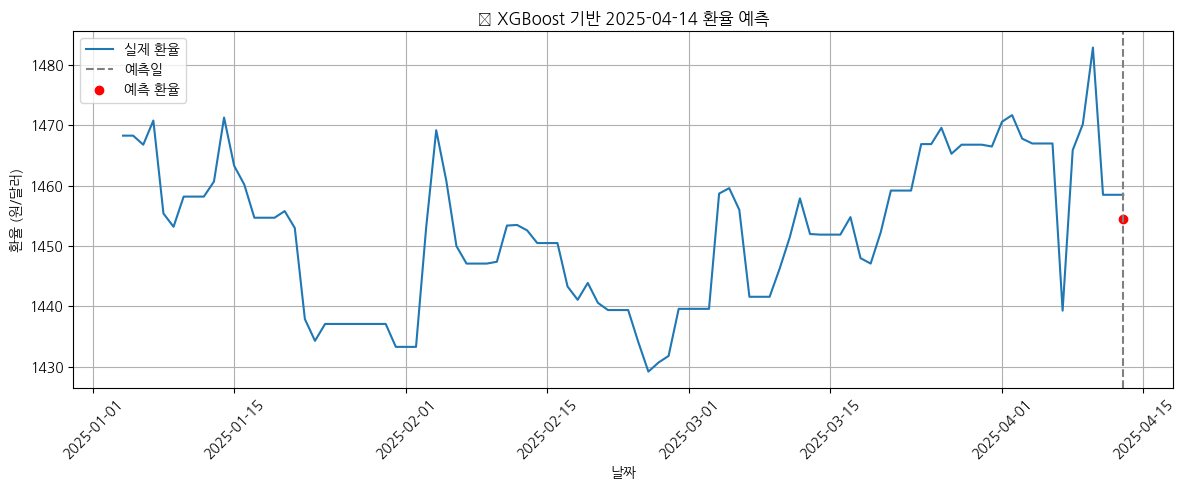

In [ ]:
# ✅ 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
PRED_DATE = "2025-04-13"  # 예측일

# ✅ 데이터 불러오기 및 정렬
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna().reset_index(drop=True)

# ✅ 쉼표 제거 및 숫자형 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 파생 변수 생성
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 스케일링
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = scaler_X.fit_transform(df[features])
df_scaled[TARGET_COL] = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 예측일 인덱스 확인
base_idx = df_scaled[df_scaled["DATE"] == pd.to_datetime(PRED_DATE)].index
if len(base_idx) == 0:
    raise ValueError(f"❌ 예측일 {PRED_DATE}은 데이터에 존재하지 않습니다.")
base_idx = base_idx[0]

if base_idx < LOOKBACK:
    raise ValueError("❌ 예측일 기준 LOOKBACK 길이의 데이터가 부족합니다.")

# ✅ 학습 데이터 생성 (오류 방지: base_idx 이상 안되도록)
X, y = [], []
for i in range(LOOKBACK, base_idx):
    X.append(df_scaled[features].iloc[i - LOOKBACK:i].values.flatten())
    y.append(df_scaled[TARGET_COL].iloc[i])

X = np.array(X)
y = np.array(y)

# ✅ XGBoost 모델 학습
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# ✅ 예측용 시퀀스 (4/14 예측)
X_pred = df_scaled[features].iloc[base_idx - LOOKBACK:base_idx].values.flatten().reshape(1, -1)
pred_scaled = model.predict(X_pred)[0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제 환율 확인
true_row = df[df["DATE"] == pd.to_datetime(PRED_DATE)]
true_value = true_row[TARGET_COL].values[0] if not true_row.empty else None

# ✅ 출력
print(f"📅 예측일: {PRED_DATE}")
print(f"🔹 예측 환율: {pred_value:.2f}")
if true_value is not None:
    mae = abs(pred_value - true_value)
    rmse = np.sqrt((pred_value - true_value)**2)
    print(f"✅ 실제 환율: {true_value:.2f}")
    print(f"📊 MAE: {mae:.2f} | RMSE: {rmse:.2f}")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

# ✅ 시각화
plt.figure(figsize=(12, 5))
plt.plot(df["DATE"].iloc[-100:], df[TARGET_COL].iloc[-100:], label="실제 환율")
plt.axvline(pd.to_datetime(PRED_DATE), color="gray", linestyle="--", label="예측일")
plt.scatter(pd.to_datetime(PRED_DATE), pred_value, color="red", label="예측 환율")
plt.title("📈 XGBoost 기반 2025-04-14 환율 예측")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

SHAP Top10으로 4/22일 예측하기

📅 예측일: 2025-04-14
🔹 예측 환율: 1318.25
⚠️ 실제 환율 데이터가 존재하지 않습니다.


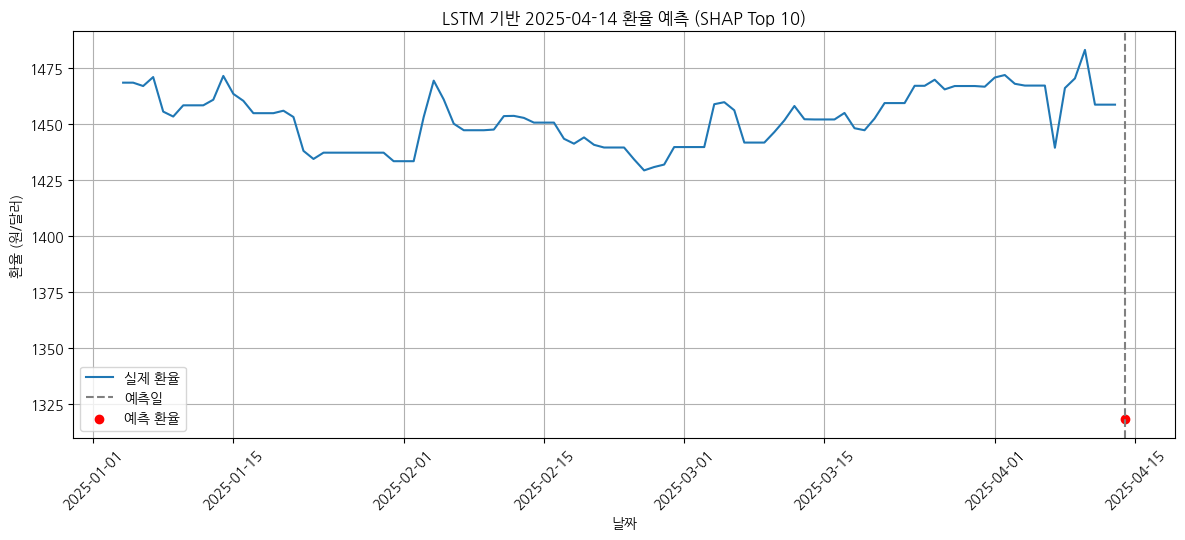

In [ ]:
# ✅ 필요 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
BASE_DATE = "2025-04-13"  # 4/22 예측을 위한 기준일
SHAP_FEATURES = [
    'PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ',
    '미국PPI', 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무'
]

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거 및 수치형 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[SHAP_FEATURES])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 인덱스
base_date = pd.to_datetime(BASE_DATE)
if base_date not in dates_seq.values:
    raise ValueError(f"❌ 기준일 {BASE_DATE} 은(는) 데이터에 없습니다.")
base_idx = dates_seq[dates_seq == base_date].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ LSTM 모델 정의 및 학습
model = Sequential([
    Input(shape=(LOOKBACK, len(SHAP_FEATURES))),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=16,
          validation_split=0.2, callbacks=[early_stop], verbose=0)

# ✅ 예측 시퀀스
X_input = X_scaled[base_idx:base_idx + LOOKBACK]
if X_input.shape[0] != LOOKBACK:
    raise ValueError("❌ LOOKBACK 길이의 입력 시퀀스가 부족합니다.")
X_input = X_input[np.newaxis, :, :]

# ✅ 예측 수행
pred_scaled = model.predict(X_input, verbose=0)[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제 환율 확인
pred_date = base_date + pd.Timedelta(days=1)
true_val = df.loc[df["DATE"] == pred_date, TARGET_COL].values

# ✅ 출력
print(f"📅 예측일: {pred_date.date()}")
print(f"🔹 예측 환율: {pred_value:.2f}")
if len(true_val) > 0:
    mae = abs(pred_value - true_val[0])
    rmse = np.sqrt((pred_value - true_val[0])**2)
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
    print(f"📊 MAE: {mae:.2f} | RMSE: {rmse:.2f}")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

# ✅ 시각화
plt.figure(figsize=(12, 5))
plt.plot(df["DATE"].iloc[-100:], df[TARGET_COL].iloc[-100:], label="실제 환율")
plt.axvline(pred_date, color="gray", linestyle="--", label="예측일")
plt.scatter(pred_date, pred_value, color="red", label="예측 환율")
plt.title(f"LSTM 기반 {pred_date.date()} 환율 예측 (SHAP Top 10)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

XGBoost SHAP Top10 4/14 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from datetime import timedelta

# 설정
LOOKBACK = 60
PRED_START = "2025-04-14"
PRED_END = "2025-04-22"
TARGET_COL = "원/미국달러(매매기준율)"
SHAP_FEATURES = [
    'PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ',
    '미국PPI', 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무'
]

# 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# 피처 선택 및 정규화
features = SHAP_FEATURES
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler_X.fit_transform(df[features])
df_scaled[TARGET_COL] = scaler_y.fit_transform(df[[TARGET_COL]])

# 시퀀스 만들기
X_scaled = df_scaled[features].values
y_scaled = df_scaled[TARGET_COL].values
dates = df_scaled["DATE"].values

X_seq, y_seq, date_seq = [], [], []
for i in range(LOOKBACK, len(X_scaled)):
    X_seq.append(X_scaled[i - LOOKBACK:i])
    y_seq.append(y_scaled[i])
    date_seq.append(dates[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)
date_seq = pd.to_datetime(date_seq)

# 기준일로 모델 학습
base_date = pd.to_datetime(PRED_START) - timedelta(days=1)
base_idx = np.where(date_seq == base_date)[0][0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# LSTM 모델
model = Sequential([
    Input(shape=(LOOKBACK, len(features))),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# 예측 루프
results = []
current_input = X_scaled[base_idx + LOOKBACK - LOOKBACK:base_idx + LOOKBACK].copy()

for d in pd.date_range(PRED_START, PRED_END):
    input_seq = current_input[np.newaxis, :, :]
    pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
    pred = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

    true_val = df.loc[df["DATE"] == d, TARGET_COL].values
    true_val = true_val[0] if len(true_val) > 0 else np.nan
    mae = abs(true_val - pred) if not np.isnan(true_val) else np.nan

    results.append({
        "날짜": d,
        "예측환율": pred,
        "실제환율": true_val,
        "MAE": mae,
        "±10원": int(abs(true_val - pred) <= 10) if not np.isnan(true_val) else np.nan,
        "±30원": int(abs(true_val - pred) <= 30) if not np.isnan(true_val) else np.nan,
        "±50원": int(abs(true_val - pred) <= 50) if not np.isnan(true_val) else np.nan,
    })

    # 예측값을 시퀀스에 반영해 업데이트
    new_row = current_input[-1].copy()
    target_index = list(features).index(TARGET_COL) if TARGET_COL in features else -1
    if target_index != -1:
        new_row[target_index] = pred_scaled
    current_input = np.vstack([current_input[1:], new_row])

# 결과
df_result = pd.DataFrame(results)
print(df_result)

# 성능 평가
df_result_no_na = df_result.dropna()
mae = df_result_no_na["MAE"].mean()
rmse = np.sqrt(((df_result_no_na["예측환율"] - df_result_no_na["실제환율"])**2).mean())
in_10 = df_result_no_na["±10원"].mean() * 100
in_30 = df_result_no_na["±30원"].mean() * 100
in_50 = df_result_no_na["±50원"].mean() * 100

print(f"\n📊 평균 MAE: {mae:.2f}")
print(f"📊 평균 RMSE: {rmse:.2f}")
print(f"✅ ±10원 포함 비율: {in_10:.2f}%")
print(f"✅ ±30원 포함 비율: {in_30:.2f}%")
print(f"✅ ±50원 포함 비율: {in_50:.2f}%")

          날짜         예측환율  실제환율  MAE  ±10원  ±30원  ±50원
0 2025-04-14  1455.360607   NaN  NaN   NaN   NaN   NaN
1 2025-04-15  1453.478774   NaN  NaN   NaN   NaN   NaN
2 2025-04-16  1452.790655   NaN  NaN   NaN   NaN   NaN
3 2025-04-17  1452.711458   NaN  NaN   NaN   NaN   NaN
4 2025-04-18  1452.886019   NaN  NaN   NaN   NaN   NaN
5 2025-04-19  1453.130132   NaN  NaN   NaN   NaN   NaN
6 2025-04-20  1453.363921   NaN  NaN   NaN   NaN   NaN
7 2025-04-21  1453.562013   NaN  NaN   NaN   NaN   NaN
8 2025-04-22  1453.722487   NaN  NaN   NaN   NaN   NaN

📊 평균 MAE: nan
📊 평균 RMSE: nan
✅ ±10원 포함 비율: nan%
✅ ±30원 포함 비율: nan%
✅ ±50원 포함 비율: nan%


5/13 환율 예측

           날짜         예측환율
20 2025-05-04  1427.968464
21 2025-05-05  1428.299257
22 2025-05-06  1428.660545
23 2025-05-07  1429.039120
24 2025-05-08  1429.407371
25 2025-05-09  1429.762736
26 2025-05-10  1430.097691
27 2025-05-11  1430.418480
28 2025-05-12  1430.718499
29 2025-05-13  1431.007633


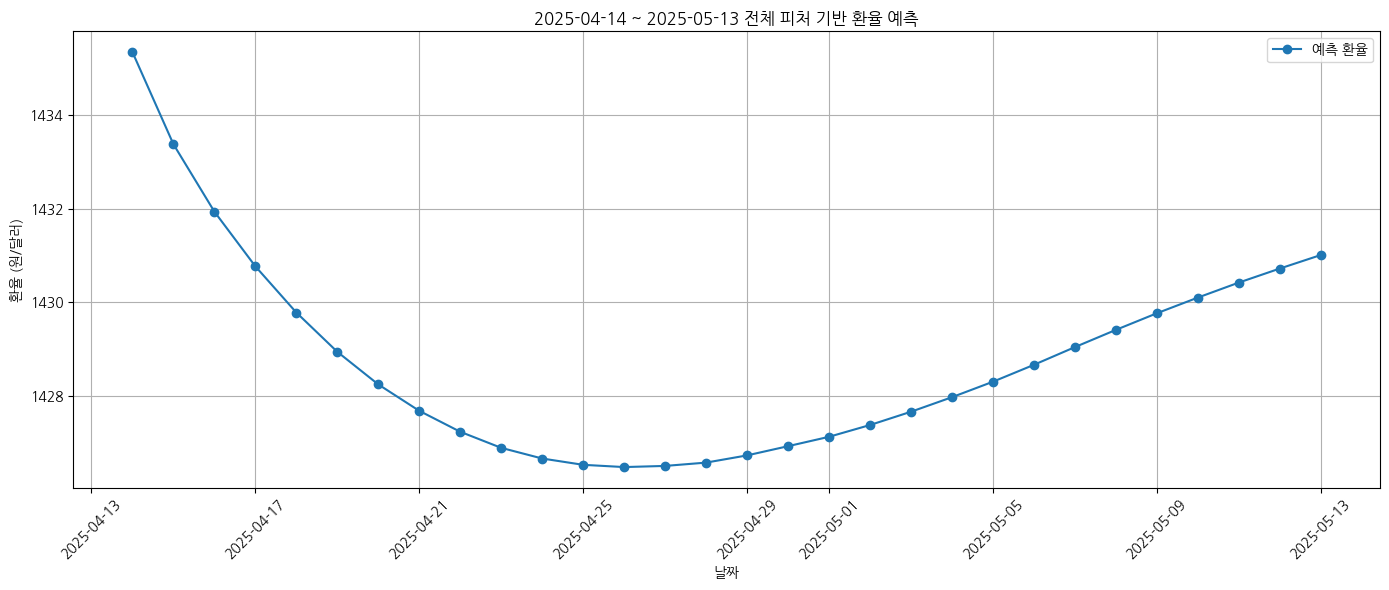

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
PRED_START_DATE = "2025-04-14"
PRED_END_DATE = "2025-05-13"

# ✅ 데이터 로드
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").dropna()

# ✅ 쉼표 제거
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 파생 변수
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 전체 피처 리스트 저장
original_features = df.columns.drop("DATE")

# ✅ 스케일링
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequence(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequence(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 설정 및 훈련 데이터 분리
base_idx = dates_seq[dates_seq == pd.to_datetime("2025-04-13")].index[0]
X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ LSTM 모델 정의
model = Sequential([
    Input(shape=(LOOKBACK, len(features))),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# ✅ 마지막 입력 시퀀스
last_seq = X_scaled[base_idx : base_idx + LOOKBACK].copy()

# ✅ 예측 날짜
forecast_dates = pd.date_range(start=PRED_START_DATE, end=PRED_END_DATE)
preds = []

# ✅ 타겟 인덱스 (정규화된 전체 피처 기준에서 찾음)
target_idx = list(original_features).index(TARGET_COL)

# ✅ 예측 루프
for date in forecast_dates:
    input_seq = last_seq[-LOOKBACK:]
    pred_scaled = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
    pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
    preds.append(pred_value)

    # 다음날 입력 시퀀스 구성
    next_row = last_seq[-1].copy()
    next_row[target_idx] = pred_scaled
    last_seq = np.vstack([last_seq[1:], next_row])

# ✅ 결과 출력
results_df = pd.DataFrame({
    "날짜": forecast_dates,
    "예측환율": preds
})

print(results_df.tail(10))

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(results_df["날짜"], results_df["예측환율"], label="예측 환율", marker="o")
plt.title("2025-04-14 ~ 2025-05-13 전체 피처 기반 환율 예측")
plt.xlabel("날짜")
plt.ylabel("환율 (원/달러)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

최신 환율 불러오기

In [ ]:
import pandas as pd
import requests
from datetime import datetime, timedelta

# ✅ ECOS 설정
API_KEY = "T4UQ50NF71Q6Y0K4NVMZ"
STAT_CODE = "731Y001"
ITEM_CODE = "0000001"
CSV_PATH = "/content/new_0418.csv"

# ✅ 최근 7일 중 데이터 있는 가장 최근 날짜 찾기
def get_latest_valid_rate():
    for i in range(1, 8):
        day = datetime.today()
        date_str = day.strftime("%Y%m%d")
        url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/kr/1/1/{STAT_CODE}/D/{date_str}/{date_str}/{ITEM_CODE}"
        try:
            r = requests.get(url)
            data = r.json()
            if "StatisticSearch" in data:
                row = data["StatisticSearch"]["row"][0]
                rate = float(row["DATA_VALUE"])
                date = datetime.strptime(row["TIME"], "%Y%m%d")
                return date, rate
        except:
            continue
    return None, None

# ✅ 실행
date, rate = get_latest_valid_rate()

if date is None:
    print("❌ 최근 유효한 환율 데이터를 찾을 수 없습니다.")
else:
    print(f"📌 환율 {rate:.2f}원 (기준일: {date.date()})")

    df = pd.read_csv(CSV_PATH)
    df["DATE"] = pd.to_datetime(df["DATE"])

    df_new = pd.DataFrame([{"DATE": date, "원/미국달러(매매기준율)": rate}])
    df_combined = pd.concat([df, df_new]).drop_duplicates(subset="DATE").sort_values("DATE")

    df_combined.to_csv(CSV_PATH, index=False)
    print("✅ CSV에 추가 완료")

📌 환율 1422.60원 (기준일: 2025-04-23)
✅ CSV에 추가 완료


In [ ]:
import pandas as pd

# ✅ 파일 경로
CSV_PATH = "/content/new_0418.csv"

# ✅ CSV 불러오기
df = pd.read_csv(CSV_PATH)
df["DATE"] = pd.to_datetime(df["DATE"])

# ✅ 원하는 구간 필터링
start_date = "2025-04-01"
end_date = "2025-04-23"
mask = (df["DATE"] >= start_date) & (df["DATE"] <= end_date)

# ✅ 환율만 출력
subset = df.loc[mask, ["DATE", "원/미국달러(매매기준율)"]].sort_values("DATE")
print(subset)

            DATE  원/미국달러(매매기준율)
23832 2025-04-01         1470.6
23833 2025-04-02         1471.7
23834 2025-04-03         1467.8
23835 2025-04-04         1467.0
23836 2025-04-05         1467.0
23837 2025-04-06         1467.0
23838 2025-04-07         1439.3
23839 2025-04-08         1465.9
23840 2025-04-09         1470.2
23841 2025-04-10         1482.9
23842 2025-04-11         1458.5
23843 2025-04-12         1458.5
23844 2025-04-13         1458.5
23845 2025-04-14         1450.8
23846 2025-04-15         1427.4
23847 2025-04-16         1423.3
23848 2025-04-17         1427.4
23849 2025-04-18         1419.9
23850 2025-04-21         1421.5
23851 2025-04-22         1418.9
23852 2025-04-23         1422.6


환율 자동화

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")

# ✅ 숫자형 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "").astype(float)

# ✅ 결측치 보간
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]
df.ffill(inplace=True)
df.bfill(inplace=True)

# ✅ 설정
LOOKBACK = 60
TARGET_COL = "원/미국달러(매매기준율)"
features = df.columns.drop(["DATE", TARGET_COL])

# ✅ 입력
input_date = input("예측할 날짜를 입력하세요 (예: 2025-04-24): ")
pred_date = pd.to_datetime(input_date)

# ✅ 학습 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)

# ✅ 모델 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_seq.shape[2])),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_seq, y_seq, epochs=30, batch_size=16, verbose=0,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# ✅ 예측용 시퀀스 추출
df_recent = df[df["DATE"] < pred_date].tail(LOOKBACK)
if len(df_recent) < LOOKBACK:
    raise ValueError("예측일 이전 30일치 데이터가 부족합니다.")

X_input = scaler_X.transform(df_recent[features]).reshape(1, LOOKBACK, -1)

# ✅ 예측
pred_scaled = model.predict(X_input)[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 최근 환율 출력
print("\n📌 최근 10일 환율")
print(df[df["DATE"] < pred_date].tail(10)[["DATE", TARGET_COL]])

# ✅ 결과 출력
print(f"\n📅 예측일: {pred_date.date()}")
print(f"🔹 예측 환율: {pred_value:.2f}")
true_val = df[df["DATE"] == pred_date][TARGET_COL].values
if len(true_val) > 0:
    print(f"✅ 실제 환율: {true_val[0]:.2f}")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

예측할 날짜를 입력하세요 (예: 2025-04-24): 2025-04-24


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

📌 최근 10일 환율
            DATE  원/미국달러(매매기준율)
23843 2025-04-12         1458.5
23844 2025-04-13         1458.5
23845 2025-04-14         1450.8
23846 2025-04-15         1427.4
23847 2025-04-16         1423.3
23848 2025-04-17         1427.4
23849 2025-04-18         1419.9
23850 2025-04-21         1421.5
23851 2025-04-22         1418.9
23852 2025-04-23         1422.6

📅 예측일: 2025-04-24
🔹 예측 환율: 1470.31
⚠️ 실제 환율 데이터가 존재하지 않습니다.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 예측할 날짜 입력
pred_input = input("예측할 날짜를 입력하세요 (예: 2025-04-24): ")
PRED_DATE = pd.to_datetime(pred_input)

# ✅ 설정값
LOOKBACK = 30
TARGET_COL = "원/미국달러(매매기준율)"
CSV_PATH = "/content/new_0418.csv"

# ✅ 데이터 불러오기
df = pd.read_csv(CSV_PATH)
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")

# ✅ 결측치 보간
df.replace(",", "", regex=True, inplace=True)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

# ✅ 최근 6개월 데이터 필터링
six_months_ago = PRED_DATE - pd.DateOffset(months=6)
df = df[df["DATE"] >= six_months_ago].reset_index(drop=True)

# ✅ 파생변수 생성
if "장단기금리차" not in df.columns:
    df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 피처 설정 및 정규화
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 기준일 인덱스 찾기 (예측일 전날까지 훈련)
base_date = PRED_DATE - timedelta(days=1)
if base_date not in dates_seq.values:
    raise ValueError(f"❌ 예측일 {PRED_DATE.date()}에 대한 시퀀스를 만들 수 없습니다.")
base_idx = dates_seq[dates_seq == base_date].index[0]

X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]

# ✅ 모델 구성 및 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_seq.shape[2])),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=16,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

# ✅ 최근 10일 환율 확인용 출력
print(f"\n📌 최근 10일 환율")
print(df[["DATE", TARGET_COL]].iloc[-10:])

# ✅ 예측 수행
X_input = X_scaled[base_idx:base_idx + LOOKBACK]
if X_input.shape[0] != LOOKBACK:
    raise ValueError("LOOKBACK 길이의 시퀀스를 확보하지 못했습니다.")
X_input = X_input[np.newaxis, :, :]

pred_scaled = model.predict(X_input, verbose=0)[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값 확인
true_val = df[df["DATE"] == PRED_DATE][TARGET_COL].values
true_val = true_val[0] if len(true_val) > 0 else None

# ✅ 결과 출력
print(f"\n📅 예측일: {PRED_DATE.date()}")
print(f"🔹 예측 환율: {pred_value:.2f}")
if true_val is not None:
    mae = abs(pred_value - true_val)
    error_pct = (mae / true_val) * 100
    accuracy = 100 - error_pct
    print(f"✅ 실제 환율: {true_val:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {accuracy:.2f}%")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

예측할 날짜를 입력하세요 (예: 2025-04-24): 2025-04-24


<ipython-input-122-abb8ac1d95d0>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
<ipython-input-122-abb8ac1d95d0>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)



📌 최근 10일 환율
          DATE  원/미국달러(매매기준율)
170 2025-04-12         1458.5
171 2025-04-13         1458.5
172 2025-04-14         1450.8
173 2025-04-15         1427.4
174 2025-04-16         1423.3
175 2025-04-17         1427.4
176 2025-04-18         1419.9
177 2025-04-21         1421.5
178 2025-04-22         1418.9
179 2025-04-23         1422.6

📅 예측일: 2025-04-24
🔹 예측 환율: 1432.99
⚠️ 실제 환율 데이터가 존재하지 않습니다.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 예측할 날짜 입력
pred_input = input("예측할 날짜를 입력하세요 (예: 2025-05-13): ")
PRED_DATE = pd.to_datetime(pred_input)

# ✅ SHAP 기반 주요 피처
shap_features = [
    'PPI', '본원 통화(달러 발행량)', '수출물가지수(원화기준)', 'NASDAQ',
    '미국PPI', 'CPI', 'KOSPI', '외환보유액(천달러)', '원유', '대외채무'
]

# ✅ 설정값
LOOKBACK = 30
TARGET_COL = "원/미국달러(매매기준율)"
CSV_PATH = "/content/new_0418.csv"

# ✅ 데이터 로딩 및 정제
df = pd.read_csv(CSV_PATH)
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")
df.replace(",", "", regex=True, inplace=True)

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.interpolate(method="linear", inplace=True)
df.fillna(method="bfill", inplace=True)

# ✅ 최근 6개월 데이터 필터링
df = df[df["DATE"] >= (PRED_DATE - pd.DateOffset(months=6))].reset_index(drop=True)

# ✅ 파생변수 생성
if "장단기금리차" not in df.columns:
    df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 정규화
features = shap_features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ base_date = 예측 전날
base_date = PRED_DATE - timedelta(days=1)
if base_date in dates_seq.values:
    base_idx = dates_seq[dates_seq == base_date].index[0]
    X_train, y_train = X_seq[:base_idx], y_seq[:base_idx]
else:
    # 예측 이어서 진행 (마지막 30일 시퀀스로부터)
    X_train, y_train = X_seq, y_seq

# ✅ 모델 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_seq.shape[2])),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=16,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=0)

# ✅ 최근 10일 환율
print("\n📌 최근 10일 환율")
print(df[["DATE", TARGET_COL]].iloc[-10:])

# ✅ 예측
last_seq = X_scaled[-LOOKBACK:]
X_input = last_seq[np.newaxis, :, :]
pred_scaled = model.predict(X_input, verbose=0)[0, 0]
pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

# ✅ 실제값
true_val = df[df["DATE"] == PRED_DATE][TARGET_COL].values
true_val = true_val[0] if len(true_val) > 0 else None

# ✅ 출력
print(f"\n📅 예측일: {PRED_DATE.date()}")
print(f"🔹 예측 환율: {pred_value:.2f}")
if true_val is not None:
    mae = abs(pred_value - true_val)
    error_pct = (mae / true_val) * 100
    accuracy = 100 - error_pct
    print(f"✅ 실제 환율: {true_val:.2f}")
    print(f"📊 MAE: {mae:.2f} | 오차율: {error_pct:.2f}% | 정답률: {accuracy:.2f}%")
else:
    print("⚠️ 실제 환율 데이터가 존재하지 않습니다.")

예측할 날짜를 입력하세요 (예: 2025-05-13): 2025-05-13


<ipython-input-130-8ac941d1c8dd>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)



📌 최근 10일 환율
          DATE  원/미국달러(매매기준율)
150 2025-04-12         1458.5
151 2025-04-13         1458.5
152 2025-04-14         1450.8
153 2025-04-15         1427.4
154 2025-04-16         1423.3
155 2025-04-17         1427.4
156 2025-04-18         1419.9
157 2025-04-21         1421.5
158 2025-04-22         1418.9
159 2025-04-23         1422.6

📅 예측일: 2025-05-13
🔹 예측 환율: 1427.41
⚠️ 실제 환율 데이터가 존재하지 않습니다.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 입력
pred_input = input("예측할 날짜를 입력하세요 (예: 2025-05-13): ")
PRED_DATE = pd.to_datetime(pred_input)

# ✅ 설정
LOOKBACK = 30
TARGET_COL = "원/미국달러(매매기준율)"
CSV_PATH = "/content/new_0418.csv"

# ✅ 데이터 불러오기
df = pd.read_csv(CSV_PATH)
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")
df.replace(",", "", regex=True, inplace=True)

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.interpolate(method="linear", inplace=True)
df.fillna(method="bfill", inplace=True)

# ✅ 파생 변수
if "장단기금리차" not in df.columns:
    df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 최근 1년 데이터 필터링
df = df[df["DATE"] >= PRED_DATE - pd.DateOffset(years=1)].reset_index(drop=True)

# ✅ 정규화
features = df.columns.drop(["DATE", TARGET_COL])
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[TARGET_COL]])

# ✅ 시퀀스 생성
def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
dates_seq = df["DATE"].iloc[LOOKBACK:].reset_index(drop=True)

# ✅ 전체 학습
model = Sequential([
    Input(shape=(LOOKBACK, X_seq.shape[2])),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_seq, y_seq, epochs=30, batch_size=16,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=0)

# ✅ 마지막 30일 시퀀스부터 예측 이어가기
last_seq = X_scaled[-LOOKBACK:]
target_idx = list(df.columns.drop("DATE")).index(TARGET_COL)

# ✅ 예측 날짜 생성
last_date = df["DATE"].iloc[-1]
pred_dates = pd.date_range(start=last_date + timedelta(days=1), end=PRED_DATE)

preds = []

for _ in pred_dates:
    X_input = last_seq[np.newaxis, :, :]
    pred_scaled = model.predict(X_input, verbose=0)[0, 0]
    pred_value = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
    preds.append(pred_value)

    next_row = last_seq[-1].copy()
    next_row[target_idx] = pred_scaled
    last_seq = np.vstack([last_seq[1:], next_row])

# ✅ 결과 출력
df_result = pd.DataFrame({
    "날짜": pred_dates,
    "예측환율": preds
})
print(df_result)

예측할 날짜를 입력하세요 (예: 2025-05-13): 2025-05-13


<ipython-input-129-f3ff25e9cb15>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


           날짜         예측환율
0  2025-04-24  1442.326663
1  2025-04-25  1444.792090
2  2025-04-26  1446.341797
3  2025-04-27  1447.281193
4  2025-04-28  1448.272747
5  2025-04-29  1448.789852
6  2025-04-30  1449.498112
7  2025-05-01  1450.053506
8  2025-05-02  1450.276879
9  2025-05-03  1450.483949
10 2025-05-04  1450.091775
11 2025-05-05  1449.679177
12 2025-05-06  1449.855458
13 2025-05-07  1450.425937
14 2025-05-08  1451.048155
15 2025-05-09  1452.099295
16 2025-05-10  1452.739945
17 2025-05-11  1452.166014
18 2025-05-12  1451.404127
19 2025-05-13  1449.810643


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").reset_index(drop=True)

# ✅ 전처리
df.replace(",", "", regex=True, inplace=True)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.ffill().bfill()  # 보간 FutureWarning 대응

# ✅ 파생변수 생성
df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 설정
TARGET_COL = "원/미국달러(매매기준율)"
features = df.columns.drop(["DATE", TARGET_COL])
X = df[features]
y = df[TARGET_COL]

# ✅ 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# ✅ TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# ✅ 평가 함수
def evaluate(model, name):
    y_true_all, y_pred_all = [], []

    for train_idx, test_idx in tscv.split(X_scaled):
        model.fit(X_scaled[train_idx], y_scaled[train_idx])
        pred = model.predict(X_scaled[test_idx])
        y_pred_all.extend(pred)
        y_true_all.extend(y_scaled[test_idx])

    y_true_all = scaler_y.inverse_transform(np.array(y_true_all).reshape(-1, 1)).flatten()
    y_pred_all = scaler_y.inverse_transform(np.array(y_pred_all).reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)

    print(f"\n📊 {name} 성능 평가 (전체 피처 기반, 시계열 분할)")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE:  {mae:.4f}")
    print(f"✅ R²:   {r2:.4f}")

# ✅ 모델 성능 평가
evaluate(RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest")
evaluate(XGBRegressor(n_estimators=100, random_state=42, verbosity=0), "XGBoost")


📊 Random Forest 성능 평가 (전체 피처 기반, 시계열 분할)
✅ RMSE: 217.6863
✅ MAE:  161.3522
✅ R²:   0.4579

📊 XGBoost 성능 평가 (전체 피처 기반, 시계열 분할)
✅ RMSE: 199.5605
✅ MAE:  144.6301
✅ R²:   0.5444


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ 데이터 불러오기
df = pd.read_csv("/content/new_0418.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")

# ✅ 쉼표 제거 및 숫자형 변환
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", "")
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ✅ 파생변수 추가
if "장단기금리차" not in df.columns:
    df["장단기금리차"] = df["국고채(10년)(%)"] - df["국고채(3년)(%)"]

# ✅ 결측치 제거
df_model = df.dropna(subset=["원/미국달러(매매기준율)"])
df_model = df_model.dropna()

# ✅ X, y 설정
X = df_model.drop(columns=["DATE", "원/미국달러(매매기준율)"])
y = df_model["원/미국달러(매매기준율)"]

# ✅ train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 랜덤 포레스트 + GridSearchCV
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# ✅ XGBoost + GridSearchCV
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.1, 0.05]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), xgb_param_grid, cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

# ✅ 평가 함수 정의
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {model_name} 성능 평가 (전체 피처 기반, 과적합 방지 포함)")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE:  {mae:.4f}")
    print(f"✅ R²:   {r2:.4f}")

# ✅ 모델 평가
evaluate_model(y_test, rf_best.predict(X_test), "Random Forest")
evaluate_model(y_test, xgb_best.predict(X_test), "XGBoost")


📊 Random Forest 성능 평가 (전체 피처 기반, 과적합 방지 포함)
✅ RMSE: 7.9063
✅ MAE:  3.8253
✅ R²:   0.9961

📊 XGBoost 성능 평가 (전체 피처 기반, 과적합 방지 포함)
✅ RMSE: 9.2556
✅ MAE:  5.7823
✅ R²:   0.9947
